In [1]:
import numpy as np
import matplotlib.pylab as plt
import re
from tables import open_file
from statistics import median, mode
from scipy.optimize import curve_fit, minimize
from math import acos, degrees, log
from matplotlib.colors import LogNorm

class clean(object):
    def __init__(self, file_name):
        self.file_name = file_name
        self.file_path = '/Users/cosmos2299/documents/data/'
        l = open_file(self.file_path + self.file_name)
        list(l)
    
        self.atstamp = l.root.absolute_timestamp[150:].flatten()
        self.r_0 = l.root.rising_0[150:].flatten()
        self.r_1 = l.root.rising_1[150:].flatten()
        self.r_2 = l.root.rising_2[150:].flatten()
        self.r_3 = l.root.rising_3[150:].flatten()
        self.f_0 = l.root.falling_0[150:].flatten()
        self.f_1 = l.root.falling_1[150:].flatten()
        self.f_2 = l.root.falling_3[150:].flatten()
        self.f_3 = l.root.falling_3[150:].flatten()
    
        self.p_jumps = ((self.atstamp.size - self.atstamp[(self.atstamp < 1e11) & (self.atstamp > -1e7)].size)/
                     self.atstamp.size) * 100
        print('percentage of high jumps in the file -', self.p_jumps)
    
    #POCAM, sDOM, PMT, LED and voltage used
    def P_S_used(self):                                         
        POCAM_re = re.compile('P[1-2]')
        SDOM_re = re.compile('SDOM[1-5]')
        frequency_re = re.compile('[0-9][0-9][0-9][0-9]Hz')
        voltage_re = re.compile('[0-9][0-9]V')
        flash_time_re = re.compile('[0-9][0-9]s')
        LED_re = re.compile('P[0-9]_[a-z]')
        PMT_re = re.compile('hld_[a-z]')

        self.SDOM_num = SDOM_re.findall(self.file_name)
        self.POCAM_num = POCAM_re.findall(self.file_name)
        frequency = frequency_re.findall(self.file_name)
        voltage = voltage_re.findall(self.file_name)
        flash_time = flash_time_re.findall(self.file_name)
        LED = LED_re.findall(self.file_name)
        PMT = PMT_re.findall(self.file_name)
    
        if PMT == ['hld_d']:
            self.PMT = 'down'
        else:
            self.PMT = 'up'
    
        if LED == ['P1_b']:
            LED = 'blue'
        if LED == ['P1_v']:
            LED = 'violet'
    
        if LED == ['P2_b']:
            LED = 'blue'
        if LED == ['P2_v']:
            LED = 'violet'
        
        graph_title = [self.POCAM_num, self.SDOM_num, self.PMT, LED, voltage]
        values = ','.join(str(v) for v in graph_title)
         
    #timestamp graph
        plt.figure(figsize=(10,9))
        plt.title(values, fontsize = 22)
        plt.ylabel('absolute_timestamps(ns)', fontsize = 19)
        plt.xlabel('index', fontsize = 19)
        plt.plot(self.atstamp, '.')
        plt.savefig(self.file_path + '/graphs/' + values + 'high_jumps.jpeg', dpi = 200)
    
    #cleaning large jumps
        elim_h_jumps = (self.atstamp < 1e11) & (self.atstamp > -1e7)
        abs_elim = self.atstamp[elim_h_jumps]
        rising_0_elim = self.r_0[elim_h_jumps]
        rising_1_elim = self.r_1[elim_h_jumps]
        rising_2_elim = self.r_2[elim_h_jumps]
        rising_3_elim = self.r_3[elim_h_jumps]
        falling_0_elim = self.f_0[elim_h_jumps]
        falling_1_elim = self.f_1[elim_h_jumps]
        falling_2_elim = self.f_2[elim_h_jumps]
        falling_3_elim = self.f_3[elim_h_jumps]
    
        plt.figure(figsize=(10,9))
        plt.title(values, fontsize = 22)
        plt.ylabel('absolute_timestamp(ns)', fontsize = 19)
        plt.xlabel('index', fontsize = 19)
        plt.plot(abs_elim, '.')
        plt.savefig(self.file_path + '/graphs/' + values + 'high_jumps_cleaned.jpeg', dpi = 200)
        plt.show()
   
        plt.figure(figsize=(10,9))
        plt.title(values + ' Negative Timestamps', fontsize = 18)
        plt.ylabel('absolute_timestamp(ns)', fontsize = 19)
        plt.plot(abs_elim, '.')
        plt.ylim(-1e7, 0)
        plt.savefig(self.file_path + '/graphs/' + values + 'negative_values.jpeg', dpi = 200)
        plt.show()

    #time difference graph
        abs_elim_diff = abs_elim[1:] - abs_elim[:-1]
    
        abs_elim_bool = abs_elim[:-1][abs_elim_diff < 0]
    
        plt.figure(figsize=(10,9))
        plt.title(values, fontsize = 22)
        plt.ylabel('absolute_timestamp difference(ns)', fontsize = 19)
        plt.xlabel('index', fontsize = 19)
        plt.plot(abs_elim_diff, '.')
        plt.savefig(self.file_path + '/graphs/' + values + 'timestamp_differences.jpeg', dpi = 200)
        plt.show()
    
        if abs_elim_bool.size != 0:
            plt.figure(figsize=(10,9))
            plt.ylabel('absolute_timestamp(ns)', fontsize = 19)
            plt.xlabel('index', fontsize = 19)
            plt.title(values + ' Jumps in Timestamps', fontsize = 16)
            plt.plot(abs_elim[abs_elim_diff.argmin()-10:abs_elim_diff.argmin()+10], '.')
            plt.savefig(self.file_path + '/graphs/' + values + 'small_jumps.jpeg', dpi = 200)
            plt.show()
    
    #cleaning small jumps
        abs_elim_diff_2 = abs_elim[1:] - abs_elim[:-1]
    
        s_jump_index = []
        s_jump_1 = []
        s_jump_2 = []
        list_1 = np.array([])

        for r in range(0, abs_elim_diff_2.size):
            if abs_elim_diff_2[r] < 0:
                s_jump_index.append(r)
                s_jump_1.append(abs_elim_diff_2[r])

        for t in range(0, len(s_jump_index)):
            select = abs_elim_diff_2[s_jump_index[t] - 10:s_jump_index[t]]
            x = s_jump_index[t] - (10 - (np.abs(select+abs_elim_diff_2[s_jump_index[t]])).argmin())
            jump_length = s_jump_index[t] - x
    
            if jump_length == 1:
                list_1 = np.append(list_1, [x+1])
            if jump_length == 2:
                list_1 = np.append(list_1,[x+1, x+2])
            if jump_length == 3:
                list_1 = np.append(list_1,[x+1, x+2, x+3])
            if jump_length == 4:
                list_1 = np.append(list_1,[x+1, x+2, x+3, x+4])
            if jump_length == 5:
                list_1 = np.append(list_1,[x+1, x+2, x+3, x+4, x+5])
            if jump_length == 6:
                list_1 = np.append(list_1,[x+1, x+2, x+3, x+4, x+5, x+6])
            if jump_length == 7:
                list_1 = np.append(list_1,[x+1, x+2, x+3, x+4, x+5, x+6, x+7])
            if jump_length == 8:
                list_1 = np.append(list_1,[x+1, x+2, x+3, x+4, x+5, x+6, x+7, x+8])
            if jump_length == 9:
                list_1 = np.append(list_1,[x+1, x+2, x+3, x+4, x+5, x+6, x+7, x+8, x+9])
            if jump_length == 10:
                list_1 = np.append(list_1,[x+1, x+2, x+3, x+4, x+5, x+6, x+7, x+8, x+9, x+10])
   
        print(list_1)
    
        abs_elim_3e = np.delete(abs_elim, list_1)
        self.abs_elim_diff_3 = abs_elim_3e[1:] - abs_elim_3e[:-1]
        
        rising_0_elim_3e = np.delete(rising_0_elim, list_1)
        rising_1_elim_3e = np.delete(rising_1_elim, list_1)
        rising_2_elim_3e = np.delete(rising_2_elim, list_1)
        rising_3_elim_3e = np.delete(rising_3_elim, list_1)
        falling_0_elim_3e = np.delete(falling_0_elim, list_1)
        falling_1_elim_3e = np.delete(falling_1_elim, list_1)
        falling_2_elim_3e = np.delete(falling_2_elim, list_1)
        falling_3_elim_3e = np.delete(falling_3_elim, list_1)
        
        plt.figure(figsize=(10,9))
        plt.title(graph_title, fontsize = 22)
        plt.ylabel('absolute_timestamp difference(ns)', fontsize = 19)
        plt.xlabel('index', fontsize = 19)
        #plt.ylim(-10000, 0)
        plt.plot(self.abs_elim_diff_3, '.')
        plt.savefig(self.file_path + '/graphs/' + values + 'small_jumps_cleaned.jpeg', dpi = 200)
        plt.show()
        
        dt_mean = (abs_elim_3e[1:] - abs_elim_3e[:-1]).mean()
        
        #cleaning faulty falling time events
        boolean = ((falling_0_elim_3e != 0) & ((falling_1_elim_3e - rising_1_elim_3e) >= 0) & 
                   ((falling_2_elim_3e - rising_2_elim_3e) >= 0) & ((falling_3_elim_3e - rising_3_elim_3e) >= 0))
        abs_elim_3 = abs_elim_3e[boolean]
        rising_0_elim_3 = rising_0_elim_3e[boolean]
        rising_1_elim_3 = rising_1_elim_3e[boolean]
        rising_2_elim_3 = rising_2_elim_3e[boolean]
        rising_3_elim_3 = rising_3_elim_3e[boolean]
        falling_0_elim_3 = falling_0_elim_3e[boolean] 
        falling_1_elim_3 = falling_1_elim_3e[boolean]
        falling_2_elim_3 = falling_2_elim_3e[boolean]
        falling_3_elim_3 = falling_3_elim_3e[boolean]
        
        #cleaning faulty falling time events
        delete = []
        for i in range(0, abs_elim_3.size):
            if ((falling_1_elim_3[i] != 0 and rising_1_elim_3[i] == 0)
                or (falling_2_elim_3[i] != 0 and rising_2_elim_3[i] == 0)
                or (falling_3_elim_3[i] != 0 and rising_3_elim_3[i] == 0)
               ):
                delete.append(i)
        
        self.abs_elim_3 = np.delete(abs_elim_3, delete)
        self.rising_0_elim_3 = np.delete(rising_0_elim_3, delete)
        self.rising_1_elim_3 = np.delete(rising_1_elim_3, delete)
        self.rising_2_elim_3 = np.delete(rising_2_elim_3, delete)
        self.rising_3_elim_3 = np.delete(rising_3_elim_3, delete)
        self.falling_0_elim_3 = np.delete(falling_0_elim_3, delete)
        self.falling_1_elim_3 = np.delete(falling_1_elim_3, delete)
        self.falling_2_elim_3 = np.delete(falling_2_elim_3, delete)
        self.falling_3_elim_3 = np.delete(falling_3_elim_3, delete)  
        
        f_r_percent_error = (abs_elim_3e.size - self.abs_elim_3.size)/(self.abs_elim_3.size) * 100
        print(f_r_percent_error)
        return (self.abs_elim_3,self.rising_0_elim_3, self.rising_1_elim_3, self.rising_2_elim_3, self.rising_3_elim_3,
                self.falling_0_elim_3, self.falling_1_elim_3, self.falling_2_elim_3, self.falling_3_elim_3, 
                self.POCAM_num, values, self.atstamp, self.p_jumps, dt_mean, f_r_percent_error, values,
                self.file_path, self.SDOM_num, self.PMT)

In [2]:
class residual(object):
    def __init__(self,rising_a_elim_3, lspace_lower, lspace_upper, lspace, lower_bound, upper_bound,
                xlim_min, xlim_max, ylim_min, ylim_max):
    
        self.t_threshold = abs_elim_3[rising_a_elim_3 > 0] + rising_a_elim_3[rising_a_elim_3 > 0]
        t_diff = self.t_threshold[1:] - self.t_threshold[:-1]
        self.events_in_peak = self.t_threshold[:-1][(t_diff[:] > lower_bound) & (t_diff[:] < upper_bound)] #selecting events in peak
    
        plt.figure(figsize=(10,9))
        _ = plt.hist(t_diff, np.linspace(lspace_lower,lspace_upper, lspace), log = True)
        plt.title(values + '- Time Difference', fontsize = 19)
        plt.xlabel('time difference(ns)', fontsize = 16)

        if POCAM_num ==['P1']:
            self.estimate_peak = 200100.71     #for POCAM_1
        if POCAM_num == ['P2']:
            self.estimate_peak = 200100.33     #for POCAM_2
    
        self.estimate_residual = self.events_in_peak%self.estimate_peak
    
        plt.figure(figsize=(10,9))
        plt.plot(self.events_in_peak, self.estimate_residual, '.')
        plt.title(values + '-time residuals of threshold 1', fontsize = 19)
        plt.xlabel('timestamps', fontsize = 16)
        plt.ylabel('time residuals', fontsize = 16)
        plt.xlim(xlim_min, xlim_max)
        plt.ylim(ylim_min,ylim_max)
        
    def minimizer(self, select_min, select_max):
        
        #Minimizer
        tmin = select_min
        tmax = select_max
        def dfunc2(delta_t):
            x = self.events_in_peak
            tres = x%delta_t
            selection = (self.events_in_peak>tmin)*(self.events_in_peak<tmax)
            return np.sum((tres[selection]-tres[selection].mean())**2)
        from scipy.optimize import minimize
        m = minimize(dfunc2, [200100.], method='Powell')
        #print(m)
        print(m.x)
        gaus_peak = m.x
        return gaus_peak
    
    def res(self, greater_than, med_bound):
        print(self.events_in_peak.size)
        est_res_diff = abs(self.estimate_residual[1:] - self.estimate_residual[:-1])
        jump_index = ([])
        est_res_diff_ji = ([])
        jump_index = np.append(jump_index, 0)
        for r in range(0, est_res_diff.size):
            if est_res_diff[r] > greater_than:
                jump_index = np.append(jump_index, r)
            
        JumpIndex = jump_index.astype(int)
            
        print('jump_index', jump_index)
        print('jump_index size', jump_index.size)
    
        self.peak_1 = [] 
        t_res_all = np.array([])
        t_res_all_all = np.array([])
        abs_elim = abs_elim_3[rising_1_elim_3 > 0] + rising_1_elim_3[rising_1_elim_3 > 0]
        
        for p in range(0, len(JumpIndex)):      

            if p == 0:
                print("index_p", p)

                v = self.events_in_peak[:][(self.events_in_peak[:] >= self.events_in_peak[0]) & 
                                      (self.events_in_peak[:] < self.events_in_peak[JumpIndex[p+1]+1])]
                print('Jump Indices',0,JumpIndex[p+1]+1)
                if v.size == 0:
                    continue
                print(v.size)
                b = self.events_in_peak[JumpIndex[1]+1]
                a = min(v)
                run_time = abs_elim[(abs_elim >= 0) & (abs_elim < b)]
            
            elif p == JumpIndex.size - 1:
                print("index_p", p)
                print('Jump Index size =', JumpIndex.size, self.events_in_peak.size - 1)
                print([JumpIndex[p]+1])
                v = self.events_in_peak[:][(self.events_in_peak[:] >= self.events_in_peak[JumpIndex[p]+1]) & 
                                      (self.events_in_peak[:] <= self.events_in_peak[self.events_in_peak.size - 1])]
            
                print('Jump Indices', JumpIndex[p]+1, self.events_in_peak.size - 1)
                a = min(v)
                run_time = abs_elim[(abs_elim >= a) & (abs_elim <= abs_elim[abs_elim.size-1])]
        
            else: 
                print("index_p", p)
                v = self.events_in_peak[:][(self.events_in_peak[:] >= self.events_in_peak[JumpIndex[p]+1]) & 
                                      (self.events_in_peak[:] < self.events_in_peak[JumpIndex[p+1]+1])]
                print('Jump Indices', JumpIndex[p]+1, JumpIndex[p+1]+1)
                print(v.size)
                b = self.events_in_peak[JumpIndex[p+1]+1]
                a = min(v)
                run_time = abs_elim[(abs_elim >= a) & (abs_elim < b)]
        
            time_res = v%gaus_peak
            time_res_all = run_time%gaus_peak
            #print('time_res length', time_res.size)
        
            plt.figure(figsize=(10,9))            #plotting time residual graph for individual runs
            plt.plot(time_res, '.')
            plt.ylabel('time_residual')
            plt.show()
    
            #Gaussian fit
            med = median(time_res)                    
            med_all = median(time_res_all)
            peak = time_res[(time_res >= med - med_bound) & (time_res <= med + med_bound)]
            peak_all = time_res_all[(time_res_all >= med_all - med_bound) & (time_res_all <= med_all + med_bound)]
    
            def gaussian(x, mean, amplitude, standard_deviation):
                return amplitude * np.exp( - ((x - mean) / standard_deviation) ** 2)

            bins = np.linspace(med-med_bound, med + med_bound, 11)
            bins_all = np.linspace(med-med_bound, med + med_bound, 11)
            data_entries_1, bins_1, _ = plt.hist(peak, bins, alpha = 0.5)
            #plt.show()
            data_entries_1_all, bins_1_all, _ = plt.hist(peak_all, bins_all, alpha = 0.5)
            #plt.show()
    
            data = peak
            data_all = peak_all
            bincenters = ((bins[:-1]+bins[1:])/2)
            bincenters_all = ((bins_all[:-1]+bins_all[1:])/2)
    
            from scipy.optimize import curve_fit
            data_entries = data_entries_1
            popt, pcov = curve_fit(gaussian, xdata = bincenters, 
                                    ydata = data_entries,  
                                    absolute_sigma = True, 
                                    p0 = (med, 10, 5),
                                    sigma = np.sqrt(data_entries))
            data_entries_all = data_entries_1_all
    
            popt_all, pcov_all = curve_fit(gaussian, xdata = bincenters_all, 
                                            ydata = data_entries_all,  
                                            absolute_sigma = True, 
                                            p0 = (med, 10, 5),
                                            sigma = np.sqrt(data_entries_all))
    
            time_res_sub = time_res - popt[0]
            time_res_sub_all = time_res_all - popt_all[0]
    
            self.peak_1.append(time_res_all) #peak_1 is for function CheckPeak

            #print(popt)
            #print(popt_all)
            t_res_all =np.append(t_res_all, time_res_sub)
            t_res_all_all =np.append(t_res_all_all, time_res_sub_all)
            
        plt.figure(figsize=(10,9))
        n, bins, patches = plt.hist(t_res_all, 480,
                                    #np.linspace(-10, 40, 100), 
                                    log = True)
        plt.title(values + '-time residuals of threshold 1', fontsize = 19)
        plt.xlabel('time_ns', fontsize = 16)
        plt.ylabel('bincount', fontsize = 16)
        plt.axvline(color = 'r')
    
        plt.figure(figsize=(10,9))
        n, bins, patches = plt.hist(t_res_all_all, 
                    #500,
                    np.linspace(-100, 200, 480), 
                    log = True)
        
        plt.title(values + '-time residuals of threshold 1', fontsize = 19)
        plt.xlabel('time_ns', fontsize = 16)
        plt.ylabel('bincount', fontsize = 16)
        plt.axvline(x = 0, color = 'r')
        plt.axvline(x = -10, color = 'k')
        plt.axvline(x = 10, color = 'k')
        plt.savefig(file_path + '/graphs/' + values + 'time resi graph', dpi = 200)
        
        plt.figure(figsize=(10,9))
        n, bins, patches = plt.hist(t_res_all_all, 
                                    #500,
                                    np.linspace(-1000, 20000, 480), 
                                    log = True)
        plt.figure(figsize=(10,9))
        n, bins, patches = plt.hist(t_res_all_all, 
                                    500,
                                    #np.linspace(-1000, 20000, 480), 
                                    log = True)
    
        plt.figure(figsize=(10,9))
        plt.axhline(t_res_all[(t_res_all<25000)].mean(), 0, 1, color='k')
        plt.plot(t_res_all, '.')
    
        what_peak = abs_elim[(t_res_all_all > 24) & (t_res_all_all < 40)]
        num_events = t_res_all_all[(t_res_all_all > -10) & (t_res_all_all < 10)]
        noise_events = t_res_all_all[(t_res_all_all < -10000) ^ (t_res_all_all > 10000)]
        return num_events.size, est_res_diff, t_res_all_all, what_peak, noise_events.size

In [3]:
def HIST2D(BinsHist):
    plt.figure(figsize=(12,12))
    abs_elim = abs_elim_3[rising_1_elim_3 > 0] + rising_1_elim_3[rising_1_elim_3 > 0]
    x = abs_elim
    y = abs_elim % gaus_peak
    h, xedges, yedges, img = plt.hist2d(x, y,
                            BinsHist,
                            #[np.linspace(0.0e10,0.2e10, 150), np.linspace(97620, 102000, 150)],
                            #[np.linspace(2.68e10, 3e10, 150), np.linspace(13410, 13500, 150)],
                            #cmin = 4 , 
                            #norm = LogNorm() 
                            )
    cb = plt.colorbar()
    
    POCAM_bins = ([])
    for j in range (0, BinsHist):
        #print(j, j+1)
        bins = h[j:j+1, 0:].flatten()
        max_ind = np.argmax(bins)
        POCAM_bins = np.append(POCAM_bins, max_ind)
        
    POCAM_diff = abs(POCAM_bins[1:] - POCAM_bins[:-1])
    
    if SDOM_num == ['SDOM5']:
        Mode = mode(POCAM_diff[POCAM_diff > 1])
        #Mode = 10
        jump_index = np.where((POCAM_diff > Mode - 25) * (POCAM_diff < Mode + 25))
    if SDOM_num == ['SDOM1']:
        Mode = 1
        jump_index = np.where((POCAM_diff > Mode - 5) * (POCAM_diff < Mode + 5))
    if SDOM_num == ['SDOM2']:
        Mode = 1
        jump_index = np.where((POCAM_diff > Mode - 25) * (POCAM_diff < Mode + 25))
    if SDOM_num == ['SDOM3']:
        Mode = 1
        jump_index = np.where((POCAM_diff > Mode - 25) * (POCAM_diff < Mode + 25))
        
    JumpIndex = (np.array(jump_index).flatten()) + 1
    print(JumpIndex)    
    
    plt.plot(POCAM_bins, '.')
    return abs_elim, BinsHist, JumpIndex, xedges, yedges, POCAM_bins, POCAM_diff

In [4]:
def calc_res(med_bound, yaxis_lbound, yaxis_ubound):
    #gaus_peak = 200100.33417353552
    a = 0
    Min = 0
    Max = JumpIndex[0]
    t_res_all = np.array([])
    peak_1 = []
    for d in range(0, JumpIndex.size + 1):
        print('run#', d)
        if d == JumpIndex.size:
            b = BinsHist
            Max = BinsHist
            print('b', b, 'Max', Max)
            select = abs_elim[(abs_elim >= a) & (abs_elim <= xedges[b])] % gaus_peak
            y_axis = int(POCAM_bins[Min:Max].mean())
            print('yaxis - ', y_axis)
            lower_bound = y_axis -  yaxis_lbound
            upper_bound = y_axis + yaxis_ubound
            time_res = select[(select >= yedges[lower_bound]) & (select <= yedges[upper_bound])]
        else:
            b = JumpIndex[d] 
            Max = JumpIndex[d]
            print('b', b, 'Max', Max)
            select = abs_elim[(abs_elim >= a) & (abs_elim < xedges[b])] % gaus_peak
            print('select size', select.size)
            y_axis = int(POCAM_bins[Min:Max].mean())
            lower_bound = y_axis -  yaxis_lbound
            upper_bound = y_axis + yaxis_ubound
            time_res = select[(select >= yedges[lower_bound]) & (select <= yedges[upper_bound])]
        
        if time_res.size == 0:
            continue
        else:
    
            med = median(time_res)
            print('median - ', med)
            peak = time_res[(time_res >= med - med_bound) & (time_res <= med + med_bound)]
    
            def gaussian(x, mean, amplitude, standard_deviation):
                return amplitude * np.exp( - ((x - mean) / standard_deviation) ** 2)
            bins = np.linspace(med - med_bound, med + med_bound, 11)
            data_entries_1, bins_1, _ = plt.hist(peak, bins, alpha = 0.5)
    
            data = peak
            bincenters = ((bins[:-1]+bins[1:])/2)
    
            from scipy.optimize import curve_fit
            data_entries = data_entries_1
            popt, pcov = curve_fit(gaussian, xdata = bincenters, 
                                    ydata = data_entries,  
                                    absolute_sigma = True, 
                                    p0 = (med, 10, 5),
                                    sigma = np.sqrt(data_entries))
    
            time_res_sub = select - popt[0]
        
            peak_1.append(time_res_sub)
        
            t_res_all =np.append(t_res_all, time_res_sub)
    
        a = xedges[b]
        Min = Max
        print('a', b, Min, 'min')
        
    plt.figure(figsize=(10,9))
    _ = plt.hist(t_res_all, 
                #500,
                np.linspace(-100, 200, 480), 
                log = True)
    plt.axvline(x = 0, color = 'r')
    plt.axvline(x = -10, color = 'k')
    plt.axvline(x = 10, color = 'k')
    
        
    plt.figure(figsize=(10,9))
    _ = plt.hist(t_res_all, 
                #500,
                np.linspace(-1000, 20000, 480), 
                log = True)
    plt.show()
    
    plt.figure(figsize=(10,9))
    _ = plt.hist(t_res_all, 
                500,
                #np.linspace(-100500, -99500, 480), 
                log = True)
    plt.show()
    
    num_events = t_res_all[(t_res_all > -10) & (t_res_all < 10)]
    
    if t_res_all.size != abs_elim.size:
        print('TRUE')

    return t_res_all, peak_1, num_events.size

In [58]:
def run_time(abs_timestamp, jumps):
    # removing negative timestamps
    negative_index_values = []
    for r in range(0, abs_timestamp.size):
        if abs_timestamp[r] < 0 and abs_timestamp[r] > -1e7:
            negative_index_values.append(r)

    if len(negative_index_values) != 0:
        r_negative_stamp = abs_timestamp[max(negative_index_values)+1:]
    else:
        r_negative_stamp = abs_timestamp[:]
    
    store_index = []
    for index, value in enumerate(r_negative_stamp):
        if r_negative_stamp[index] <= -1e7 or r_negative_stamp[index] >= 1e11:
            store_index.append(index)
            #print(index, value)
    #high jumps
    store_sum = ([])
    if jumps == 0.0:
        sum_1 = r_negative_stamp[r_negative_stamp.size - 1] - r_negative_stamp[0]
        Ncuts_h_size = 0
        
    else:
        Ncuts_h = []
        time = ([])
        for values in range(0, len(store_index)):
            if values == 0 and store_index[values] != 0:
                time_diff = r_negative_stamp[store_index[values]-1] - r_negative_stamp[0]
                time = np.append(time, time_diff)
                print(store_index[values]-1)
                print()
    
            if values == len(store_index) - 1:
                time_diff = r_negative_stamp[r_negative_stamp.size - 1] - r_negative_stamp[store_index[values]+1]
                time = np.append(time, time_diff)
                print(store_index[values]+1)
            else:
                if store_index[values+1] - store_index[values]!= 1:
                    Ncuts_h.append(values+1)
                    time_diff = r_negative_stamp[store_index[values+1]-1] - r_negative_stamp[store_index[values]+1]
                    time = np.append(time, time_diff)
                    print(store_index[values+1]-1, store_index[values]+1)
        print(time[0:1000])
        print(r_negative_stamp[store_index[0]-1] - r_negative_stamp[0])
        print(r_negative_stamp[r_negative_stamp.size-1] - r_negative_stamp[store_index[len(store_index) - 1]+1])
        print(store_index[0]-1)
        Ncuts_h_size = len(Ncuts_h)
        
        sum_1 = time.sum()
    r_high_jumps = r_negative_stamp[(r_negative_stamp < 1e11) & (r_negative_stamp > -1e7)]
        
    r_high_diff = r_high_jumps[1:] - r_high_jumps[:-1]
    
    s_jump_index = []
    s_jump_1 = []
    s_jump_2 = []
    list_1 = ([])

    for r in range(0, r_high_diff.size):
        if r_high_diff[r] < 0:  
            s_jump_index.append(r)
            s_jump_1.append(r_high_diff[r])
            #print(s_jump_index)

    for t in range(0, len(s_jump_index)):
        #print("index",s_jump_index[t])
        #print("index value", abs_elim_diff_2[s_jump_index[t]])
    
        select =r_high_diff[s_jump_index[t] - 10:s_jump_index[t]]
        #print("select", select)
        x = s_jump_index[t] - (10 - (np.abs(select+r_high_diff[s_jump_index[t]])).argmin())
        #print("argmin", np.abs(select+abs_elim_diff_2[s_jump_index[t]]).argmin())
        #print(x)
    
        jump_length = s_jump_index[t] - x
    
        #print("jump length", jump_length)
    
       # print("abs_elim_2.size",abs_elim_2.size)
        if jump_length == 1:
            list_1 = np.append(list_1,[x+1])
        if jump_length == 2:
            list_1 = np.append(list_1,[x+1, x+2])
        if jump_length == 3:
            list_1 = np.append(list_1,[x+1, x+2, x+3])
        if jump_length == 4:
            list_1 = np.append(list_1,[x+1, x+2, x+3, x+4])
        if jump_length == 5:
            list_1 = np.append(list_1,[x+1, x+2, x+3, x+4, x+5])
        if jump_length == 6:
            list_1 = np.append(list_1,[x+1, x+2, x+3, x+4, x+5, x+6])
        if jump_length == 7:
            list_1 = np.append(list_1,[x+1, x+2, x+3, x+4, x+5, x+6, x+7])
        if jump_length == 8:
            list_1 = np.append(list_1,[x+1, x+2, x+3, x+4, x+5, x+6, x+7, x+8])
        if jump_length == 9:
            list_1 = np.append(list_1,[x+1, x+2, x+3, x+4, x+5, x+6, x+7, x+8, x+9])
        if jump_length == 10:
            list_1 = np.append(list_1,[x+1, x+2, x+3, x+4, x+5, x+6, x+7, x+8, x+9, x+10])
            
    if len(list_1) == 0:
        run_time = sum_1
        Ncuts = Ncuts_h_size
        error_rtime = (2 * Ncuts * dt_mean) * 1e-9
    else:
        list_int = list_1.astype(int)
        
        Ncuts_s = []
        for values_s in range(0, len(list_1)):
            if values_s == len(list_1) - 1:
                continue
            else:
                if list_1[values_s+1] - list_1[values_s]!= 1:
                    Ncuts_s.append(values_s)
        print(len(Ncuts_s))
    
        Ncuts = Ncuts_h_size + len(Ncuts_s)
        print(Ncuts)
        error_rtime = (2 * Ncuts * dt_mean) * 1e-9
        
        # small jumps
        store_sum_1 = []
        store_sum_2 = ([])
        for k in range(0, len(list_int)):
            if k == 0 and list_int[k] != 0:
                po = r_high_jumps[list_int[k]-1]
                store_sum_1.append(po)
                print(k,list_int[k], po, 'p')
                if list_int[k] != list_int[k+1] - 1:
                    po = r_high_jumps[list_int[k+1]-1]
                    qo = r_high_jumps[list_int[k] + 1]
                    print(k, list_int[k], po, 'p')
                    print(k, list_int[k], qo, 'q')
                    store_sum_1.append(po)
                    store_sum_2 = np.append(store_sum_2, qo)
            elif k == len(list_int) - 1:
                qo = r_high_jumps[list_int[k]+1]
                store_sum_2 = np.append(store_sum_2, qo)
                print(k,list_int[k],qo, 'q')
            elif list_int[k+1] == list_int[k]+1:
                continue
            elif list_int[k] != list_int[k+1] - 1:
                po = r_high_jumps[list_int[k+1]-1]
                qo = r_high_jumps[list_int[k] + 1]
                print(k, list_int[k], po, 'p')
                print(k, list_int[k], qo, 'q')
                store_sum_1.append(po)
                store_sum_2 = np.append(store_sum_2, qo)
            #print(k, p)

            #store_sum_1.append(po)
            #store_sum_2 = np.append(store_sum_2, qo)
        
        sum_2 = sum(store_sum_2 - store_sum_1)
        run_time = sum_1 - sum_2
        print('time removed(small jumps) - ', sum_2)
     
    print('timestamp of the last event - ', abs_timestamp[abs_timestamp.size - 1])
    print('eliminating high jumps and summing - ', sum_1)
    print('run time - ', run_time)
    
    run_time = run_time * 1e-9
    return run_time, error_rtime

In [6]:
def angl_dist():
    SDOM_size = 0.3
    POCAM_size = 0.2
    
    POCAM2_loc = 107.66 
    POCAM1_loc = 109.79
    
    SDOM1up_loc = 69.79 - SDOM_size
    SDOM2up_loc = 49.40 - SDOM_size
    SDOM3up_loc = 29.98 - SDOM_size
    SDOM4up_loc = 29.96 - SDOM_size
    SDOM5up_loc = 69.10 - SDOM_size
    
    string_distance = 37
    
    def pyth(a, b, c):
        d = a - b
        e = np.sqrt(d**2 + c**2)
        return e
    
    if POCAM_num == ['P2'] and SDOM_num == ['SDOM1'] and PMT == 'up' :
        distance = pyth(POCAM2_loc, SDOM1up_loc, string_distance)
        angle = degrees(acos((POCAM2_loc - SDOM1up_loc)/distance))
        
    if POCAM_num == ['P2'] and SDOM_num == ['SDOM2'] and PMT == 'up' :
        distance = pyth(POCAM2_loc, SDOM2up_loc, string_distance)
        angle = degrees(acos((POCAM2_loc - SDOM2up_loc)/distance))
        
    if POCAM_num == ['P2'] and SDOM_num == ['SDOM3'] and PMT == 'up' :
        distance = pyth(POCAM2_loc, SDOM3up_loc, string_distance)
        angle = degrees(acos((POCAM2_loc - SDOM3up_loc)/distance))
    
    if POCAM_num == ['P2'] and SDOM_num == ['SDOM5'] and PMT == 'up' :
        distance = POCAM2_loc - SDOM5up_loc
        angle = 0
        
    if POCAM_num == ['P1'] and SDOM_num == ['SDOM1'] and PMT == 'up' :
        distance = POCAM1_loc - SDOM1up_loc
        angle = 0
        
    if POCAM_num == ['P1'] and SDOM_num == ['SDOM4'] and PMT == 'up' :
        distance = pyth(POCAM1_loc, SDOM4up_loc, string_distance)
        angle = degrees(acos((POCAM1_loc - SDOM4up_loc)/distance))
        
    if POCAM_num == ['P1'] and SDOM_num == ['SDOM5'] and PMT == 'up' :
        distance = pyth(POCAM1_loc, SDOM5up_loc, string_distance)
        angle = degrees(acos((POCAM1_loc - SDOM5up_loc)/distance))
        
    data=np.array([-65, 0.9461212989738365,
    -60, 0.9559174264331389,
    -55, 0.9627747156546507,
    -50, 0.9715912303680229,
    -45, 0.9764892940976742,
    -40.000000000000014, 0.9823669705732556,
    -34.999999999999986, 0.9892242597947672,
    -30.000000000000014, 0.992163098032558,
    -25, 0.9931427107784883,
    -20.000000000000014, 0.9941223235244185,
    -15, 0.9951019362703488,
    -10, 0.9951019362703488,
    -5, 0.9970611617622093,
    5, 0.996081549016279,
    10, 0.997061161762209,
    14.999999999999972, 0.9970611617622093,
    20, 0.9970611617622093,
    25, 0.9951019362703488,
    30, 0.9951019362703488,
    35.00000000000003, 0.9911834852866278,
    40, 0.9872650343029068,
    45, 0.9813873578273253,
    49.99999999999997, 0.9725708431139531,
    55, 0.9657135538924414,
    60, 0.9588562646709297,
    64.99999999999997, 0.9500397499575575])

    from scipy import interpolate

    fcn = interpolate.interp1d(data[::2], data[1::2])

    angle_cr = fcn(angle)
        
    return distance, angle_cr

In [7]:
def correction(num_events, angle_cr, run_time):
    error_nevents = (num_events/angle_cr)
    eve_p_sec = (num_events/angle_cr)/run_time
    #n_eve_p_sec = (noise_events)/run_time
    return eve_p_sec, error_nevents

In [25]:
a = clean('20181205_092552_UTC_SDOM5_FLASH_SANTACLAUS_P2_violet_both_5000Hz_16V_60s_18339132719.hld_up.hdf5')

percentage of high jumps in the file - 1.815690909649096


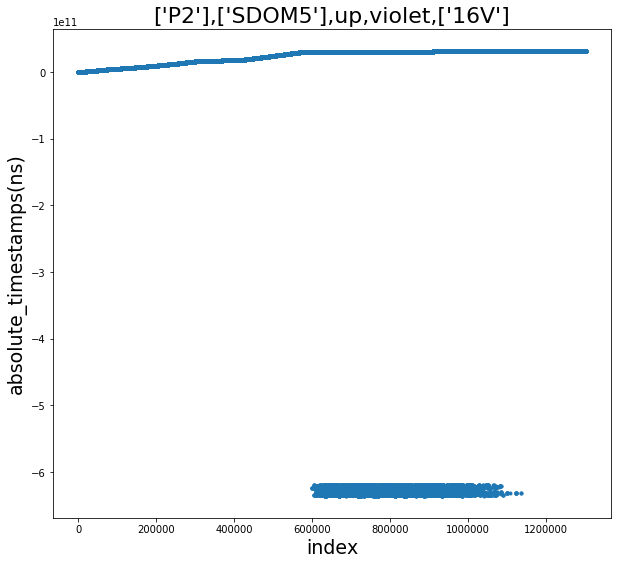

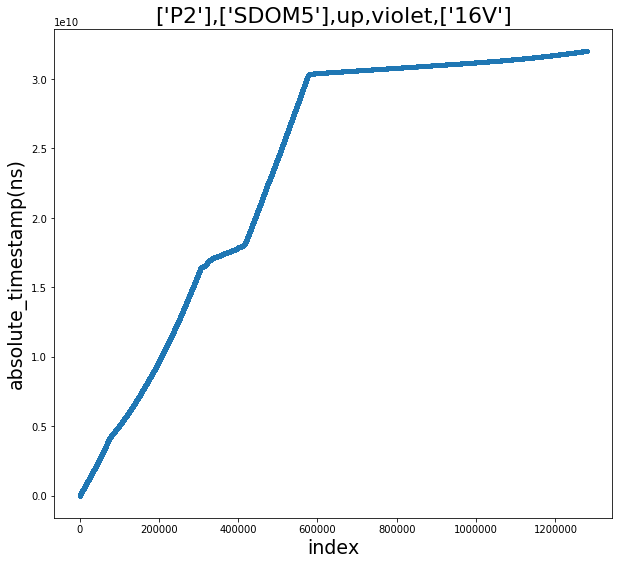

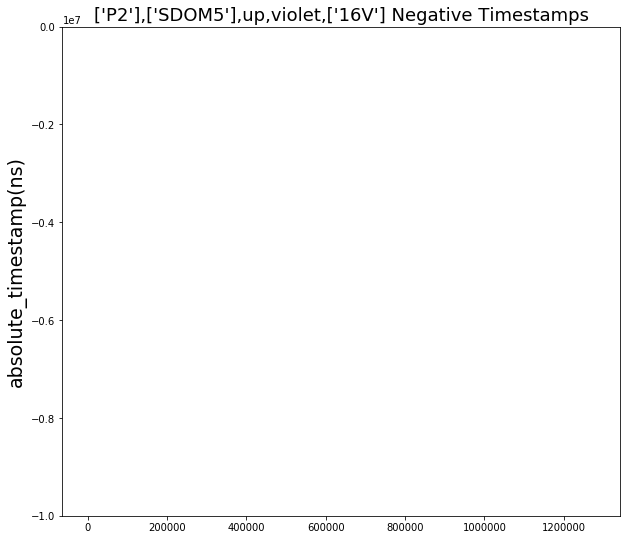

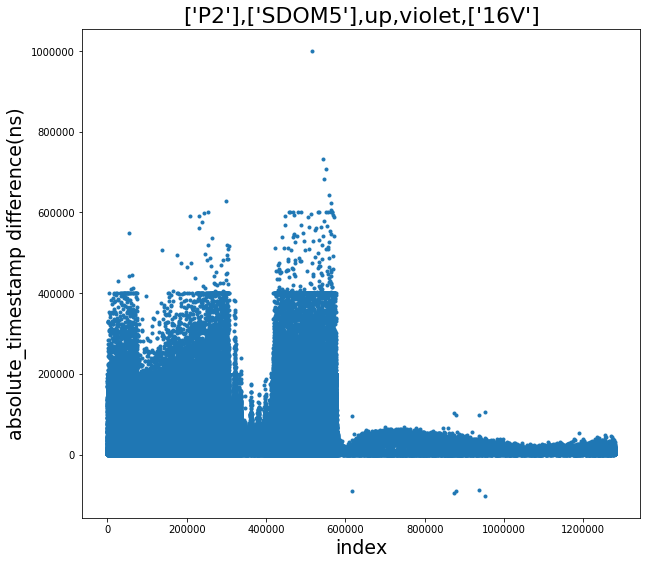

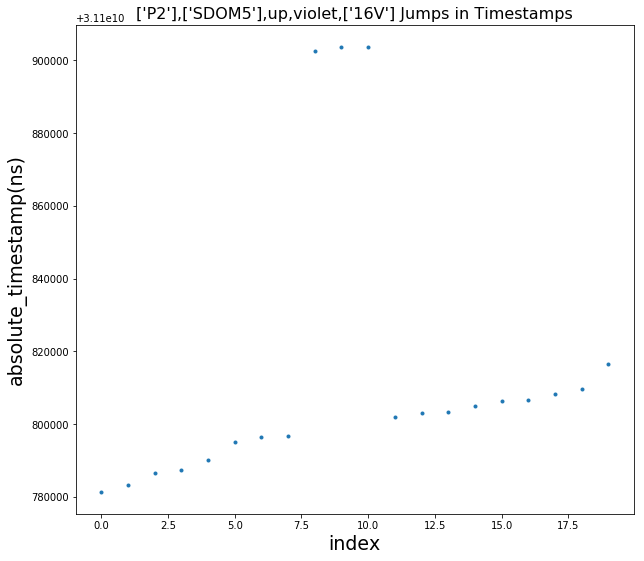

[615635. 615636. 873327. 877949. 877950. 877951. 877952. 877953. 937808.
 937809. 937810. 937811. 937812. 952941. 952942. 952943.]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:166: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:170: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:171: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:173: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the futur

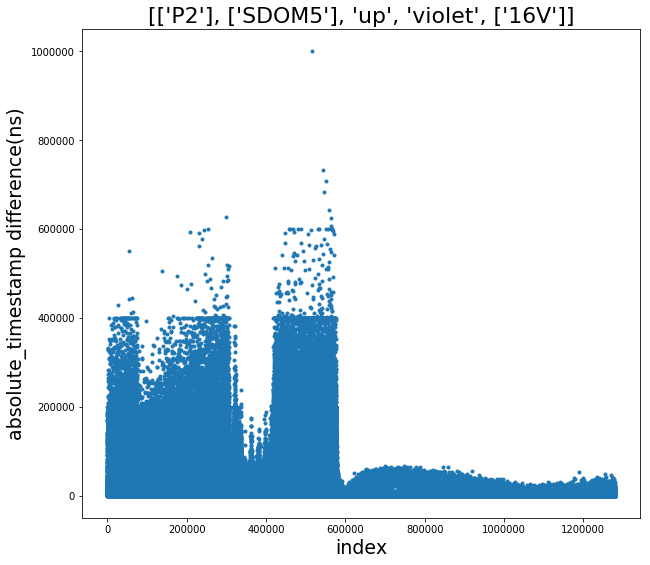

1.3183093326321358


In [26]:
(abs_elim_3, rising_0_elim_3, rising_1_elim_3, rising_2_elim_3, rising_3_elim_3,
 falling_0_elim_3, falling_1_elim_3, falling_2_elim_3, falling_3_elim_3, POCAM_num, values,
atstamp, p_jumps, dt_mean, f_r, values, file_path, SDOM_num, PMT) = a.P_S_used()

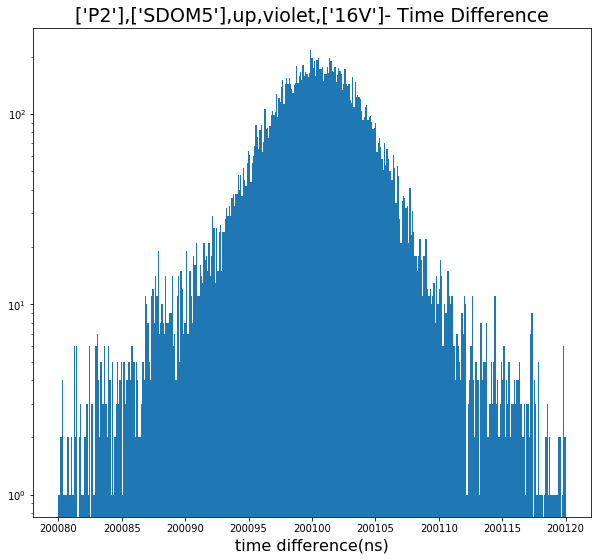

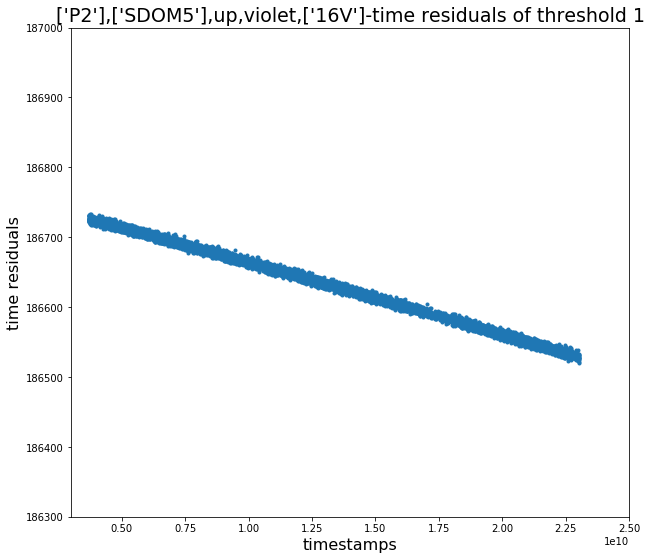

In [34]:
r1 = residual(rising_1_elim_3,200080, 200120, 400, 
                                200095, 200105,
             0.3e10,2.5e10,186300, 187000)

In [35]:
gaus_peak = r1.minimizer(0.75e10, 2.0e10)

200100.32795663626


[ 95 152 953]


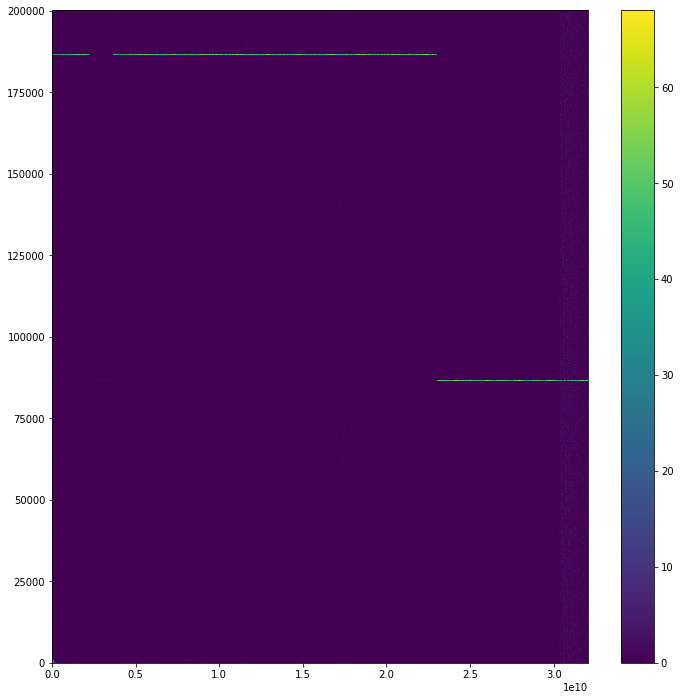

In [40]:
abs_elim, BinsHist, JumpIndex, xedges, yedges, POCAM_bins, POCAM_diff = HIST2D(1325)

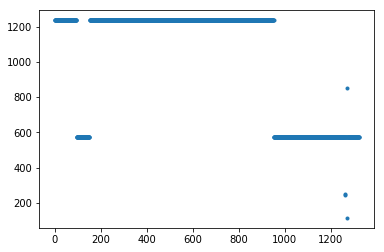

In [41]:
plt.plot(POCAM_bins, '.')

run# 0
b 95 Max 95
select size 7620
median -  186663.47601853052
a 95 95 min
run# 1
b 152 Max 152
select size 4296
median -  86664.20602399466
a 152 152 min
run# 2
b 953 Max 953
select size 66758
median -  186766.03772675595
a 953 953 min
run# 3
b 1325 Max 1325
yaxis -  571
median -  86761.1682883132
a 1325 1325 min


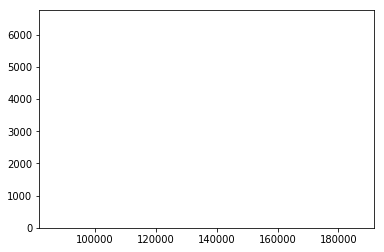

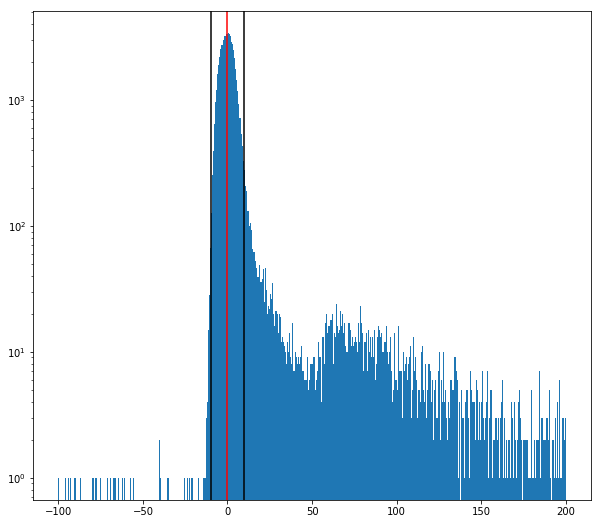

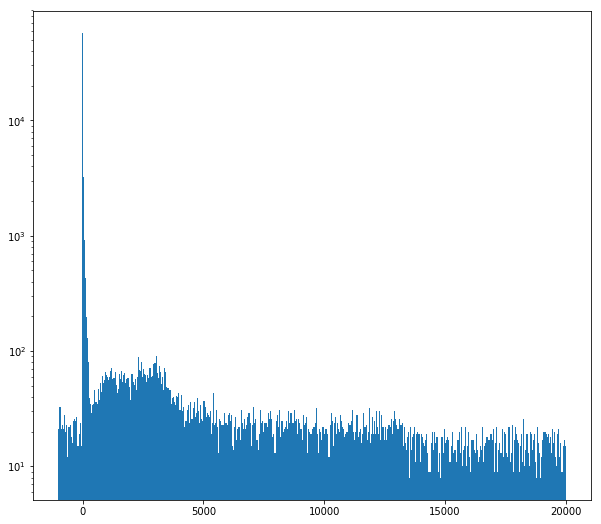

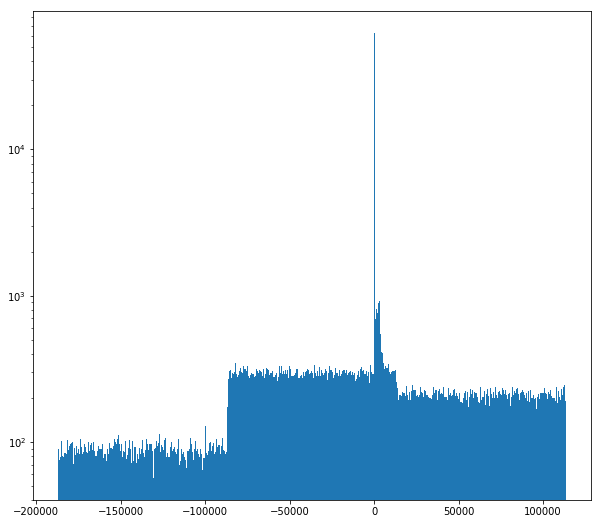

In [43]:
t_res_all1, peak_1, num_events1 = calc_res(10, 5, 5)

In [44]:
RunTime1, error_rtime1 = run_time(atstamp, p_jumps)

600541

600651 600546
604951 600653
605436 604953
605665 605441
606078 605669
606319 606081
607218 606324
607927 607227
608398 607931
609058 608403
609619 609062
609814 609621
609869 609817
610196 609874
610347 610204
610458 610351
610605 610465
610659 610608
610763 610665
610865 610766
611018 610869
611128 611020
611233 611134
611289 611237
611344 611291
611497 611350
611915 611505
612322 611918
612377 612328
612890 612380
612989 612895
613095 612991
613387 613097
613600 613391
613695 613605
614373 613700
614429 614382
614638 614431
614791 614642
614845 614793
615139 614848
615666 615142
615721 615668
616129 615727
617281 616132
617439 617284
617584 617443
617693 617586
617750 617704
617962 617753
618259 617964
618314 618263
618470 618320
618524 618473
618634 618526
618689 618636
618848 618695
618998 618852
619163 619001
619219 619170
619274 619222
619329 619277
619385 619335
619440 619389
619603 619442
619763 619606
619871 619769
620030 619877
620196 620035
620250 620203
620305 62026

690661 690554
690716 690670
690772 690726
690888 690779
690944 690894
691055 690947
691112 691064
691168 691114
691226 691174
691284 691234
691452 691286
691509 691461
691566 691514
691623 691569
691681 691627
691736 691686
691791 691741
691904 691793
691961 691910
692018 691963
692075 692023
692130 692077
692186 692137
692243 692192
692355 692247
692413 692370
692468 692417
692523 692475
692579 692531
692636 692582
692746 692642
692803 692750
692915 692806
692972 692917
693029 692981
693087 693039
693258 693092
693428 693266
693484 693433
693540 693496
693596 693545
693652 693599
693765 693659
693821 693768
693876 693827
693933 693883
693990 693941
694047 694004
694159 694050
694217 694165
694330 694221
694386 694333
694440 694394
694666 694451
694724 694678
694780 694726
694836 694783
694950 694843
695007 694961
695063 695010
695118 695068
695175 695131
695232 695177
695287 695236
695453 695292
695508 695462
695565 695517
695622 695574
695678 695635
695791 695683
695845 695799
696068

758341 758295
758398 758345
758510 758407
758565 758516
758621 758568
758676 758625
758733 758679
758790 758738
758845 758792
758957 758850
759013 758960
759125 759016
759236 759129
759292 759240
759347 759295
759404 759356
759518 759406
759574 759521
759628 759577
759740 759634
759797 759745
759909 759799
759965 759913
760021 759972
760131 760023
760189 760141
760245 760198
760301 760249
760356 760305
760467 760358
760525 760473
760581 760530
760639 760589
760752 760641
760807 760755
760864 760809
760918 760872
760973 760922
761030 760977
761087 761034
761143 761095
761200 761149
761258 761206
761316 761271
761373 761320
761429 761375
761540 761432
761598 761544
761655 761602
761712 761661
761768 761716
761824 761780
761879 761830
761935 761889
761991 761938
762047 761994
762104 762055
762160 762111
762217 762170
762274 762219
762333 762283
762389 762340
762503 762399
762617 762505
762731 762626
762788 762738
762845 762791
762902 762852
762957 762909
763014 762967
763071 763017
763183

839244 839140
839414 839253
839468 839419
839523 839477
839579 839527
839637 839584
839693 839643
839750 839696
839807 839759
839919 839812
839976 839925
840032 839979
840089 840039
840147 840091
840203 840154
840314 840206
840370 840318
840426 840372
840484 840431
840540 840489
840595 840545
840651 840602
840708 840658
840820 840712
840877 840823
840987 840879
841101 840994
841214 841114
841273 841218
841330 841281
841385 841334
841440 841387
841498 841445
841555 841508
841612 841559
841723 841617
841778 841727
841889 841782
842003 841891
842061 842016
842173 842063
842231 842182
842287 842236
842343 842291
842398 842350
842454 842401
842510 842459
842564 842513
842621 842568
842677 842631
842734 842679
842791 842737
842846 842793
842903 842848
842959 842907
843016 842964
843072 843018
843129 843075
843184 843133
843353 843188
843464 843355
843520 843470
843577 843522
843634 843584
843690 843645
843746 843697
843802 843749
843858 843806
843916 843869
844023 843925
844135 844029
844191

916641 916482
916748 916649
916911 916758
916965 916918
917020 916970
917075 917024
917131 917082
917187 917134
917342 917195
917399 917345
917454 917405
917564 917458
917619 917566
917675 917622
917730 917677
917785 917732
918060 917788
918117 918067
918171 918119
918339 918174
918450 918346
918505 918456
918617 918510
918673 918621
918729 918678
918785 918731
918897 918793
919211 918899
919268 919216
919323 919272
919379 919329
919435 919386
919490 919442
919545 919497
919600 919548
919656 919607
919713 919666
919769 919715
919824 919771
919935 919827
919991 919938
920102 919998
920158 920110
920269 920161
920374 920273
920430 920379
920539 920432
920597 920549
920651 920599
920761 920658
920872 920763
920927 920877
921095 920931
921152 921100
921208 921154
921263 921211
921320 921276
921425 921323
921481 921432
921537 921486
921649 921544
921705 921655
921867 921710
921922 921877
921977 921926
922034 921979
922090 922041
922145 922094
922200 922151
922312 922208
922367 922323
922422

4
5180
0 615635 30452999988.73273 p
1 615636 30947299980.1571 p
1 615636 30453011055.710938 q
2 873327 30956095963.166264 p
2 873327 30947306450.625 q
7 877953 31070998581.277588 p
7 877953 30956111057.796883 q
12 937812 31100796671.096188 p
12 937812 31071017927.078117 q
15 952943 31100801978.867188 q
time removed(small jumps) -  57285.64825439453
timestamp of the last event -  32032994777.10205
eliminating high jumps and summing -  31856496696.869896
run time -  31856439411.22164


In [47]:
distance1, angle_cr1 = angl_dist()

In [48]:
eve_p_sec1, error_nevents1 = correction(num_events1, angle_cr1, RunTime1)

In [49]:
eve_p_sec1

1841.6733561186534

In [71]:
b = clean('20181205_092552_UTC_SDOM1_FLASH_SANTACLAUS_P2_violet_both_5000Hz_16V_60s_18339132719.hld_up.hdf5')

percentage of high jumps in the file - 0.0


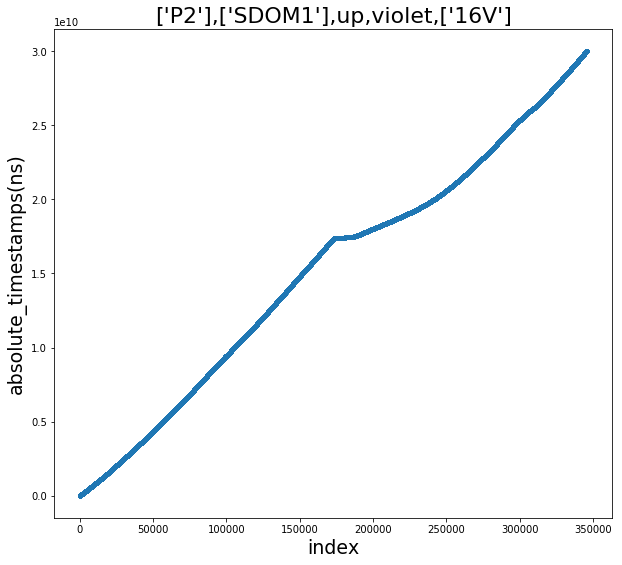

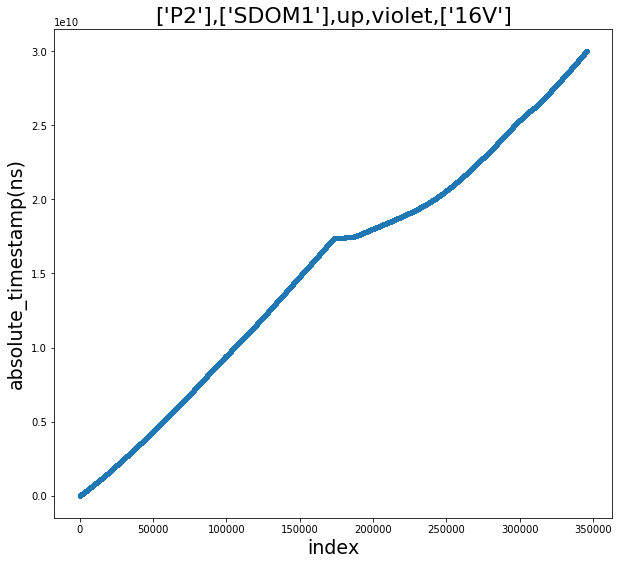

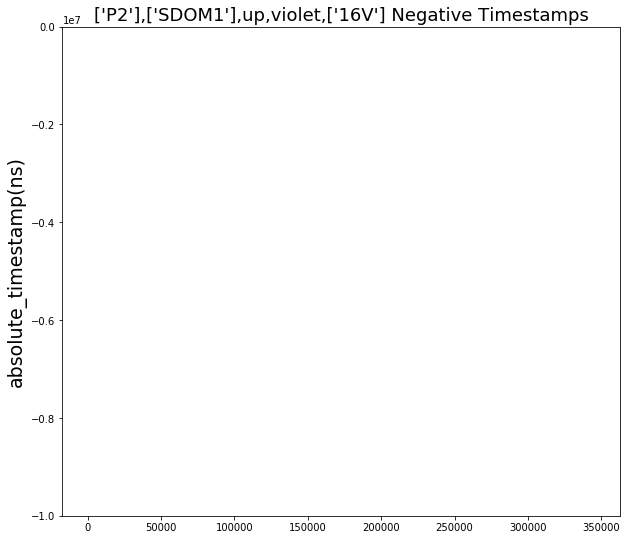

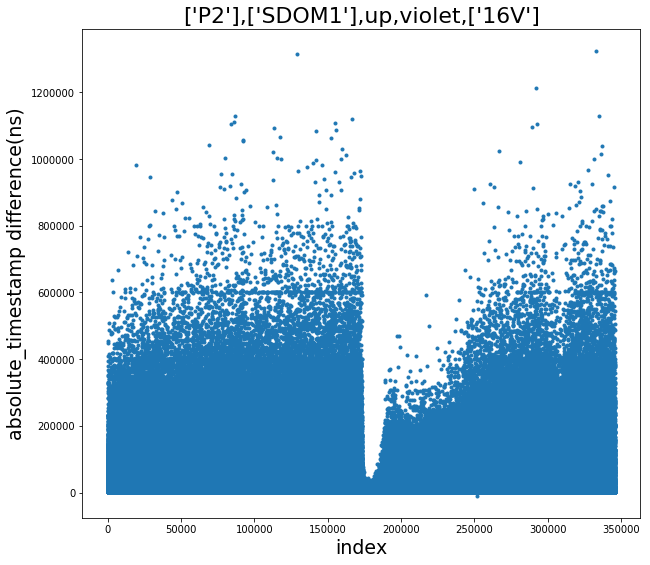

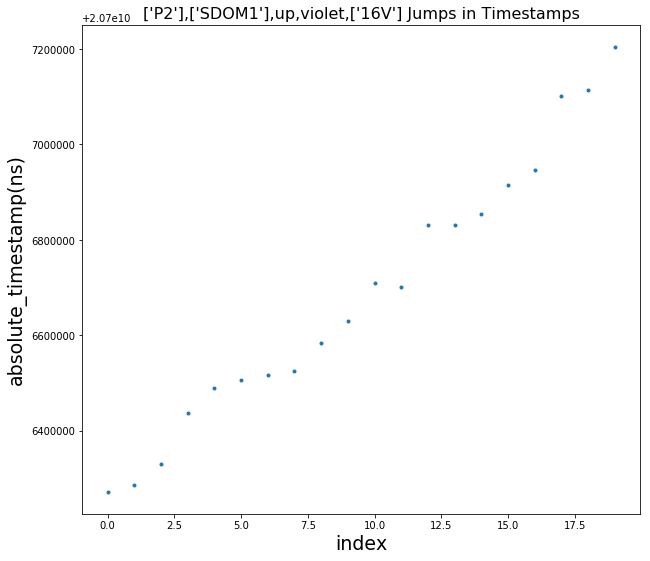

[251556. 251557. 251558. 251559. 251560.]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:166: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:170: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:171: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:173: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the futur

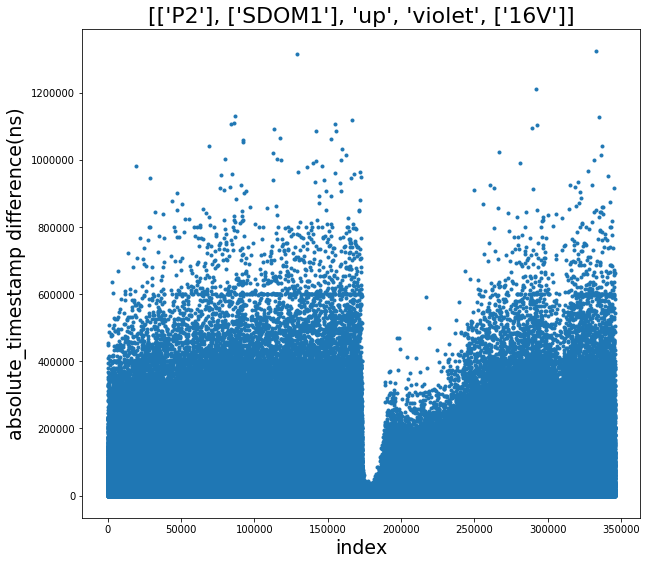

0.8288823062928582


In [72]:
(abs_elim_3, rising_0_elim_3, rising_1_elim_3, rising_2_elim_3, rising_3_elim_3,
 falling_0_elim_3, falling_1_elim_3, falling_2_elim_3, falling_3_elim_3, POCAM_num, values,
atstamp, p_jumps, dt_mean, f_r, values, file_path, SDOM_num, PMT) = b.P_S_used()

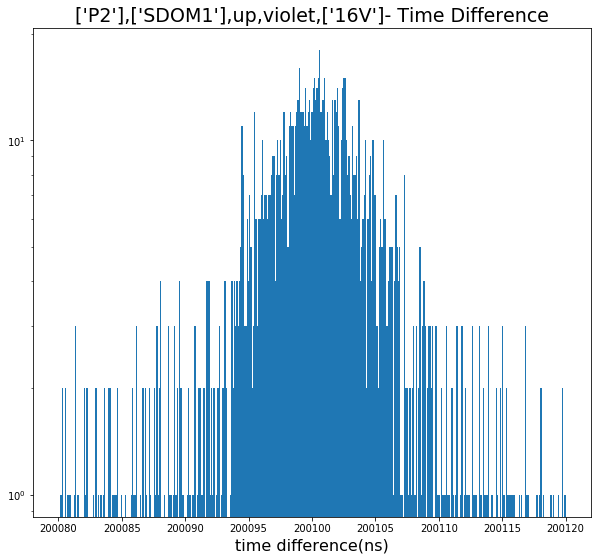

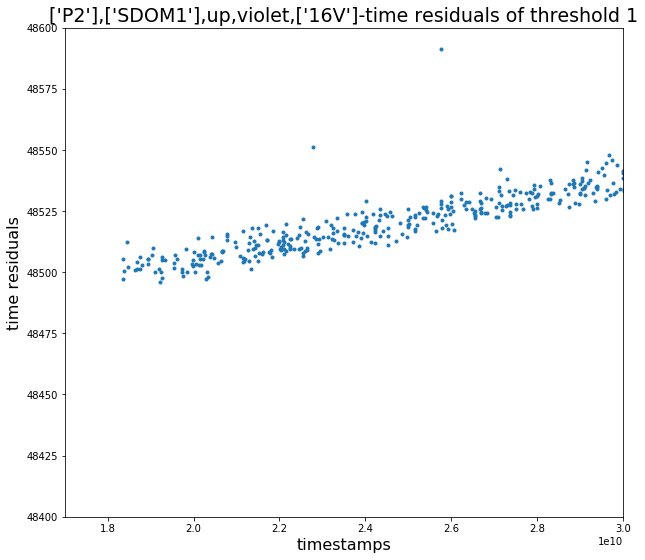

In [73]:
r2 = residual(rising_1_elim_3,200080, 200120, 400, 
                                200095, 200105,
             1.7e10,3.0e10,48400, 48600)

In [74]:
gaus_peak = r2.minimizer(2.2e10, 3.0e10)

200100.33066016817


[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 24

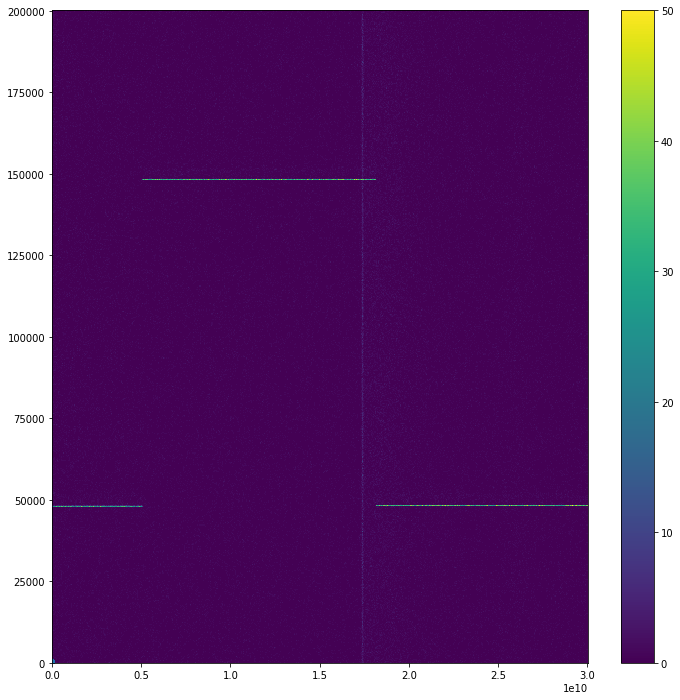

In [75]:
abs_elim, BinsHist, JumpIndex, xedges, yedges, POCAM_bins, POCAM_diff = HIST2D(625)

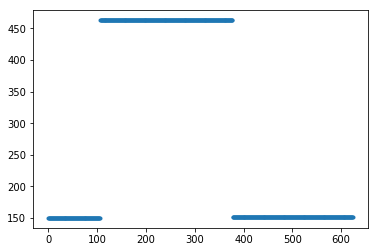

In [76]:
plt.plot(POCAM_bins, '.')

run# 0
b 1 Max 1
select size 183
median -  48326.72221520147
a 1 1 min
run# 1
b 2 Max 2
select size 190
median -  48327.098944434605
a 2 2 min
run# 2
b 3 Max 3
select size 188
median -  48326.623303728324
a 3 3 min
run# 3
b 4 Max 4
select size 165
median -  48330.1654626823
a 4 4 min
run# 4
b 5 Max 5
select size 172
median -  48327.524773982674
a 5 5 min
run# 5
b 6 Max 6
select size 177
median -  48326.210163237396
a 6 6 min
run# 6
b 7 Max 7
select size 159
median -  48328.469338560884
a 7 7 min
run# 7
b 8 Max 8
select size 139
median -  48325.73945001008
a 8 8 min
run# 8
b 9 Max 9
select size 179
median -  48327.926099378295
a 9 9 min
run# 9
b 10 Max 10
select size 161
median -  48328.37184184461
a 10 10 min
run# 10
b 11 Max 11
select size 123
median -  48327.81047069382
a 11 11 min
run# 11
b 12 Max 12
select size 184
median -  48326.42775981473
a 12 12 min
run# 12
b 13 Max 13
select size 177
median -  48327.08732865748
a 13 13 min
run# 13
b 14 Max 14
select size 154
median -  48329.8

a 109 109 min
run# 108
b 110 Max 110
select size 111
median -  148432.57811139818
a 110 110 min
run# 109
b 111 Max 111
select size 128
median -  148434.31258786988
a 111 111 min
run# 110
b 112 Max 112
select size 135
median -  148433.2235960048
a 112 112 min
run# 111
b 113 Max 113
select size 134
median -  148433.50374021474
a 113 113 min
run# 112
b 114 Max 114
select size 107
median -  148432.673454966
a 114 114 min
run# 113
b 115 Max 115
select size 112
median -  148433.65875466086
a 115 115 min
run# 114
b 116 Max 116
select size 120
median -  148431.80734994105
a 116 116 min
run# 115
b 117 Max 117
select size 110
median -  148434.30232276104
a 117 117 min
run# 116
b 118 Max 118
select size 145
median -  148434.7081793352
a 118 118 min
run# 117
b 119 Max 119
select size 134
median -  148433.75190308873
a 119 119 min
run# 118
b 120 Max 120
select size 126
median -  148435.2290858207
a 120 120 min
run# 119
b 121 Max 121
select size 123
median -  148434.75374474964
a 121 121 min
run# 12

a 210 210 min
run# 209
b 211 Max 211
select size 120
median -  148436.43422535763
a 211 211 min
run# 210
b 212 Max 212
select size 137
median -  148436.2693579245
a 212 212 min
run# 211
b 213 Max 213
select size 124
median -  148434.98179327132
a 213 213 min
run# 212
b 214 Max 214
select size 119
median -  148436.38058156945
a 214 214 min
run# 213
b 215 Max 215
select size 111
median -  148438.5330022428
a 215 215 min
run# 214
b 216 Max 216
select size 128
median -  148437.3369656569
a 216 216 min
run# 215
b 217 Max 217
select size 124
median -  148437.79634729357
a 217 217 min
run# 216
b 218 Max 218
select size 148
median -  148435.40679832085
a 218 218 min
run# 217
b 219 Max 219
select size 115
median -  148437.05800971598
a 219 219 min
run# 218
b 220 Max 220
select size 120
median -  148436.48239171074
a 220 220 min
run# 219
b 221 Max 221
select size 134
median -  148438.17908131337
a 221 221 min
run# 220
b 222 Max 222
select size 115
median -  148437.90470278746
a 222 222 min
run# 

a 313 313 min
run# 312
b 314 Max 314
select size 106
median -  148439.36647451608
a 314 314 min
run# 313
b 315 Max 315
select size 112
median -  148439.7906817026
a 315 315 min
run# 314
b 316 Max 316
select size 114
median -  148438.35168371798
a 316 316 min
run# 315
b 317 Max 317
select size 91
median -  148438.83259048074
a 317 317 min
run# 316
b 318 Max 318
select size 118
median -  148439.36634409748
a 318 318 min
run# 317
b 319 Max 319
select size 97
median -  148439.00458672285
a 319 319 min
run# 318
b 320 Max 320
select size 108
median -  148437.25890736215
a 320 320 min
run# 319
b 321 Max 321
select size 122
median -  148439.64236876543
a 321 321 min
run# 320
b 322 Max 322
select size 138
median -  148439.96597636442
a 322 322 min
run# 321
b 323 Max 323
select size 127
median -  148439.14507450984
a 323 323 min
run# 322
b 324 Max 324
select size 133
median -  148439.1497159144
a 324 324 min
run# 323
b 325 Max 325
select size 118
median -  148438.46203959713
a 325 325 min
run# 3

a 415 415 min
run# 413
b 416 Max 416
select size 188
median -  48439.422758594475
a 416 416 min
run# 414
b 417 Max 417
select size 191
median -  48438.84636424693
a 417 417 min
run# 415
b 418 Max 418
select size 169
median -  48441.07854377956
a 418 418 min
run# 416
b 419 Max 419
select size 186
median -  48440.20489241002
a 419 419 min
run# 417
b 420 Max 420
select size 195
median -  48440.26309712522
a 420 420 min
run# 418
b 421 Max 421
select size 184
median -  48440.73497236427
a 421 421 min
run# 419
b 422 Max 422
select size 165
median -  48439.88854335518
a 422 422 min
run# 420
b 423 Max 423
select size 171
median -  48440.380395894055
a 423 423 min
run# 421
b 424 Max 424
select size 167
median -  48439.078362498665
a 424 424 min
run# 422
b 425 Max 425
select size 146
median -  48439.52103716774
a 425 425 min
run# 423
b 426 Max 426
select size 176
median -  48441.857083014256
a 426 426 min
run# 424
b 427 Max 427
select size 190
median -  48439.95276643016
a 427 427 min
run# 425
b

a 517 517 min
run# 515
b 518 Max 518
select size 107
median -  48439.533703270834
a 518 518 min
run# 516
b 519 Max 519
select size 128
median -  48439.88690013751
a 519 519 min
run# 517
b 520 Max 520
select size 148
median -  48439.20067680256
a 520 520 min
run# 518
b 521 Max 521
select size 119
median -  48438.15872143276
a 521 521 min
run# 519
b 522 Max 522
select size 125
median -  48440.22122735396
a 522 522 min
run# 520
b 523 Max 523
select size 125
median -  48441.80222231662
a 523 523 min
run# 521
b 524 Max 524
select size 103
median -  48438.990909252636
a 524 524 min
run# 522
b 525 Max 525
select size 131
median -  48438.62636739301
a 525 525 min
run# 523
b 526 Max 526
select size 140
median -  48440.34995742839
a 526 526 min
run# 524
b 527 Max 527
select size 153
median -  48440.225649943764
a 527 527 min
run# 525
b 528 Max 528
select size 140
median -  48439.85136616291
a 528 528 min
run# 526
b 529 Max 529
select size 133
median -  48438.39262665436
a 529 529 min
run# 527
b 

a 619 619 min
run# 617
b 620 Max 620
select size 105
median -  48438.99610166422
a 620 620 min
run# 618
b 621 Max 621
select size 105
median -  48440.74277406026
a 621 621 min
run# 619
b 622 Max 622
select size 124
median -  48438.3231704878
a 622 622 min
run# 620
b 623 Max 623
select size 127
median -  48439.46802302019
a 623 623 min
run# 621
b 624 Max 624
select size 111
median -  48441.0179567782
a 624 624 min
run# 622
b 625 Max 625
yaxis -  151
median -  48441.597693712625
a 625 625 min


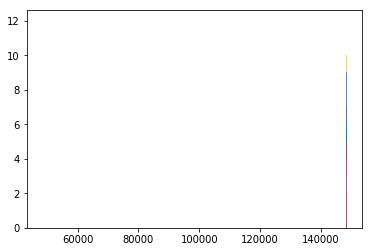

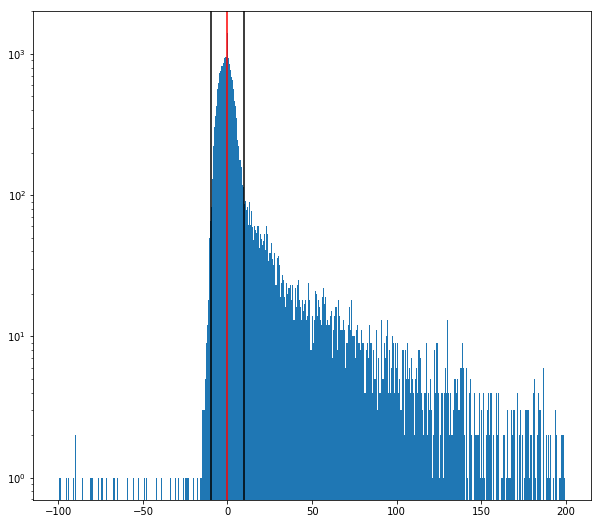

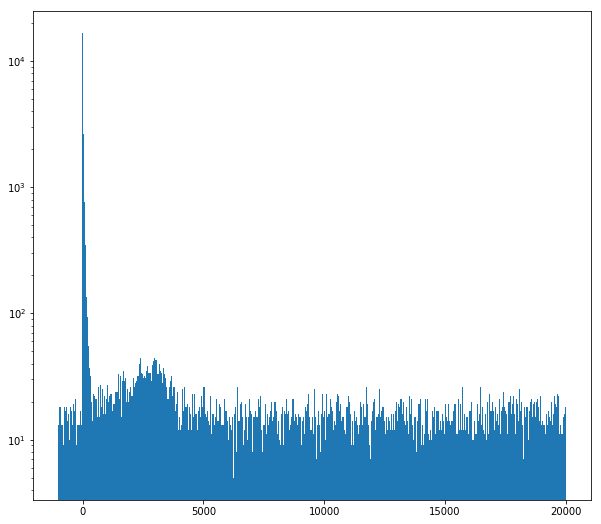

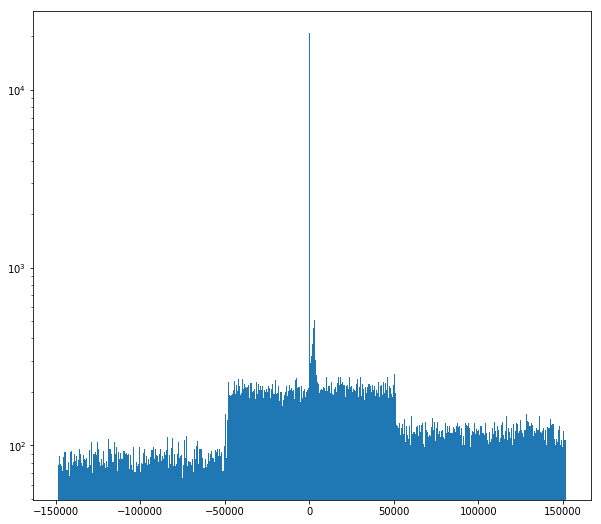

In [77]:
t_res_all2, peak_1, num_events2 = calc_res(10, 2, 1)

In [78]:
RunTime2, error_rtime2 = run_time(atstamp, p_jumps)

0
0
0 251556 20706506991.84375 p
4 251560 20706701091.55469 q
time removed(small jumps) -  194099.7109413147
timestamp of the last event -  30028944499.226562
eliminating high jumps and summing -  30020487407.496094
run time -  30020293307.785152


In [79]:
distance2, angle_cr2 = angl_dist()

In [80]:
eve_p_sec2, error_nevents2 = correction(num_events2, angle_cr2, RunTime2)

In [81]:
eve_p_sec2

573.2884782101639

In [82]:
c = clean('20181205_092552_UTC_SDOM2_FLASH_SANTACLAUS_P2_violet_both_5000Hz_16V_60s_18339132719.hld_up.hdf5')

percentage of high jumps in the file - 1.8430364340228378


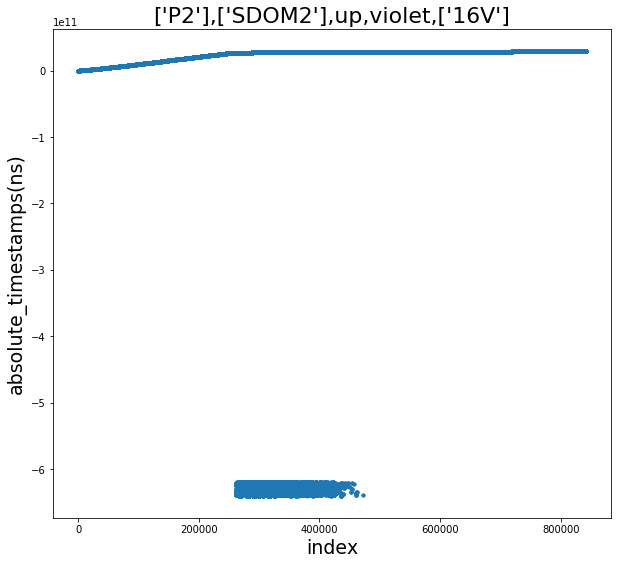

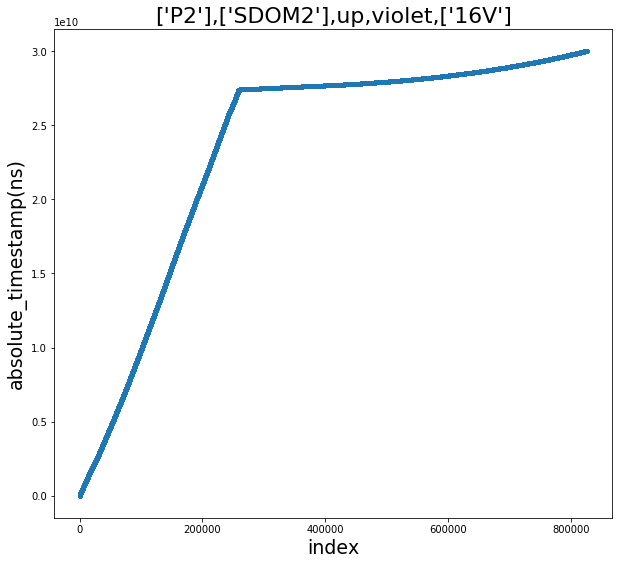

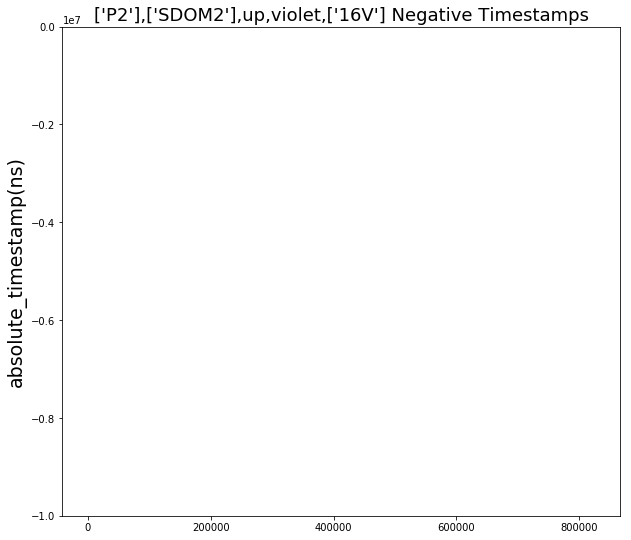

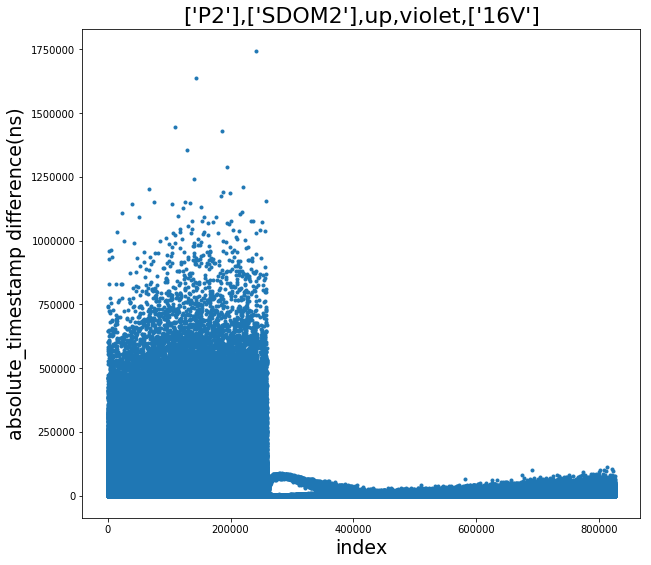

[]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:166: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:170: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:171: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:173: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the futur

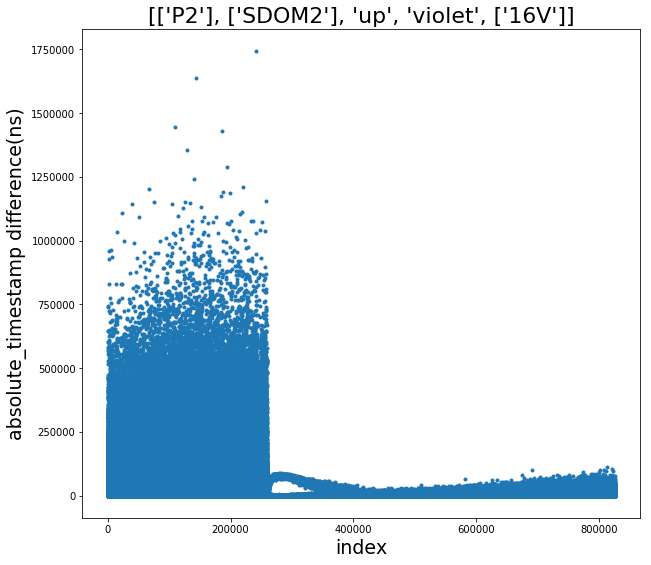

0.6291277752053226


In [83]:
(abs_elim_3, rising_0_elim_3, rising_1_elim_3, rising_2_elim_3, rising_3_elim_3,
 falling_0_elim_3, falling_1_elim_3, falling_2_elim_3, falling_3_elim_3, POCAM_num, values,
atstamp, p_jumps, dt_mean, f_r, values, file_path, SDOM_num, PMT) = c.P_S_used()

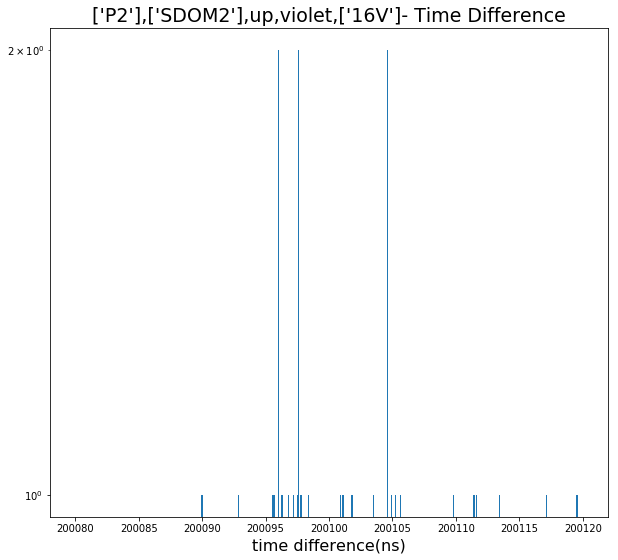

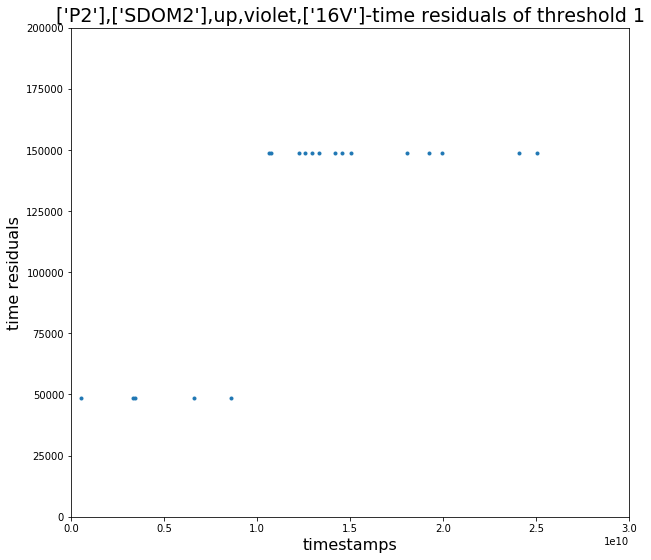

In [84]:
r3 = residual(rising_1_elim_3,200080, 200120, 400, 
                                200095, 200105,
             0.0e10,3.0e10,0, 200000)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 139 144 147]


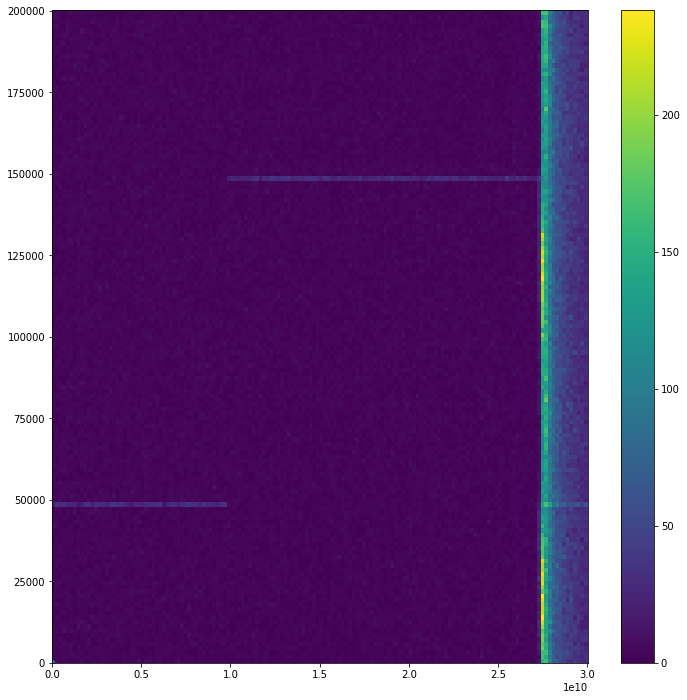

In [88]:
abs_elim, BinsHist, JumpIndex, xedges, yedges, POCAM_bins, POCAM_diff = HIST2D(150)

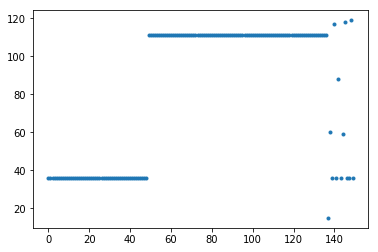

In [89]:
plt.plot(POCAM_bins, '.')

run# 0
b 1 Max 1
select size 449
median -  48514.97616114805
a 1 1 min
run# 1
b 2 Max 2
select size 450
median -  48515.05861350233
a 2 2 min
run# 2
b 3 Max 3
select size 474
median -  48518.041121653194
a 3 3 min
run# 3
b 4 Max 4
select size 484
median -  48513.23336451035
a 4 4 min
run# 4
b 5 Max 5
select size 506
median -  48513.792548054786
a 5 5 min
run# 5
b 6 Max 6
select size 516
median -  48516.90879650756
a 6 6 min
run# 6
b 7 Max 7
select size 429
median -  48514.23645363422
a 7 7 min
run# 7
b 8 Max 8
select size 532
median -  48515.32368941864
a 8 8 min
run# 8
b 9 Max 9
select size 526
median -  48514.808119301015
a 9 9 min
run# 9
b 10 Max 10
select size 547
median -  48518.11664710683
a 10 10 min
run# 10
b 11 Max 11
select size 500
median -  48516.981863544235
a 11 11 min
run# 11
b 12 Max 12
select size 492
median -  48514.52701168918
a 12 12 min
run# 12
b 13 Max 13
select size 447
median -  48521.84062932359
a 13 13 min
run# 13
b 14 Max 14
select size 480
median -  48517.98

select size 386
median -  148728.16558479963
a 114 114 min
run# 113
b 115 Max 115
select size 378
median -  148726.69830868606
a 115 115 min
run# 114
b 116 Max 116
select size 367
median -  148728.76723141008
a 116 116 min
run# 115
b 117 Max 117
select size 409
median -  148729.483437682
a 117 117 min
run# 116
b 118 Max 118
select size 373
median -  148729.67453570623
a 118 118 min
run# 117
b 119 Max 119
select size 376
median -  148724.99301247043
a 119 119 min
run# 118
b 120 Max 120
select size 409
median -  148730.75884673337
a 120 120 min
run# 119
b 121 Max 121
select size 394
median -  148725.95242172905
a 121 121 min
run# 120
b 122 Max 122
select size 392
median -  148732.6227382652
a 122 122 min
run# 121
b 123 Max 123
select size 410
median -  148725.0281195553
a 123 123 min
run# 122
b 124 Max 124
select size 391
median -  148725.37891264923
a 124 124 min
run# 123
b 125 Max 125
select size 365
median -  148727.76218202082
a 125 125 min
run# 124
b 126 Max 126
select size 378
medi

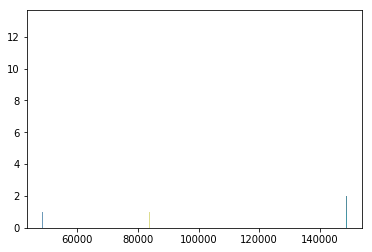

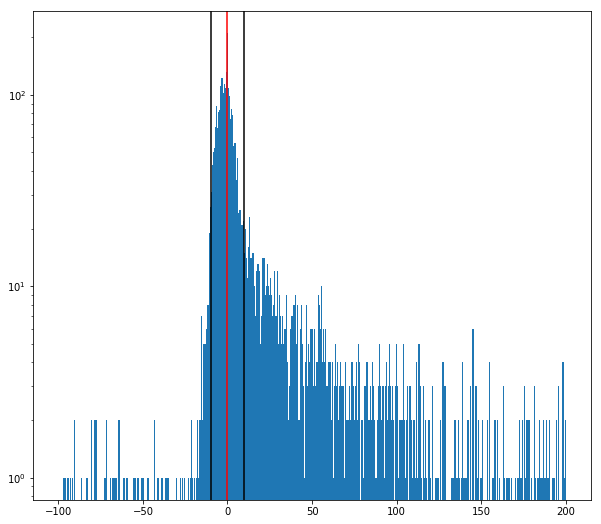

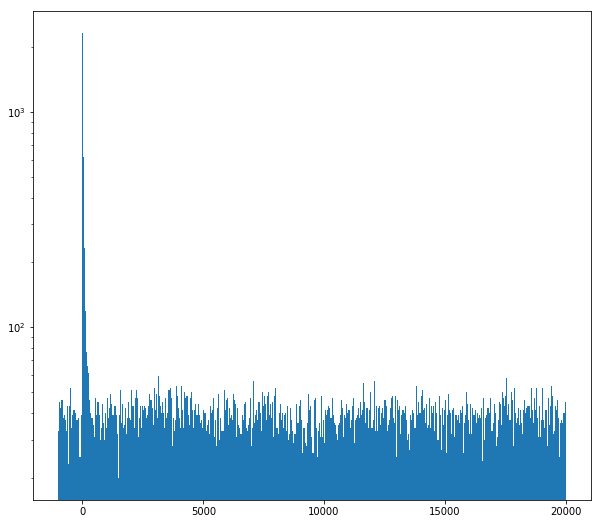

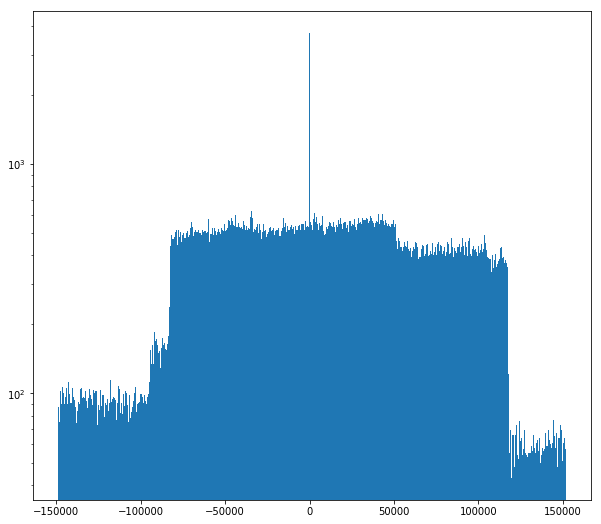

In [90]:
t_res_all3, peak_1, num_events3 = calc_res(15, 2, 2)

In [91]:
RunTime3, error_rtime3 = run_time(atstamp, p_jumps)

260884

260940 260891
261096 260943
261194 261101
261249 261196
261304 261251
261414 261306
261470 261421
261525 261474
261579 261531
261691 261582
261746 261697
261858 261749
261914 261860
261971 261917
262082 261976
262138 262088
262194 262145
262250 262202
262414 262262
262470 262419
262525 262475
262582 262529
262694 262589
262750 262696
262806 262758
262860 262808
262916 262866
262972 262919
263026 262975
263082 263037
263140 263088
263196 263147
263252 263200
263308 263262
263365 263318
263422 263369
263480 263428
263537 263490
263593 263545
263649 263602
263706 263654
263761 263716
263818 263770
263875 263825
263931 263881
263987 263939
264045 263998
264103 264049
264160 264111
264218 264169
264276 264220
264334 264282
264389 264344
264446 264399
264504 264454
264561 264506
264618 264568
264676 264631
264734 264685
264791 264744
264848 264799
264906 264850
264961 264911
265018 264975
265074 265021
265131 265094
265188 265135
265246 265196
265304 265259
265362 265317
265420 26536

338214 338166
338327 338216
338384 338334
338496 338392
338551 338505
338608 338563
338664 338610
338721 338666
338834 338729
338891 338842
338948 338897
339005 338959
339062 339015
339120 339077
339176 339125
339232 339182
339289 339234
339347 339299
339405 339366
339462 339419
339518 339466
339575 339521
339631 339586
339686 339635
339741 339693
339798 339745
339856 339802
339913 339859
339969 339921
340025 339975
340082 340027
340252 340092
340366 340259
340423 340371
340592 340435
340646 340596
340703 340653
340815 340709
340873 340826
340929 340877
340985 340933
341042 340993
341099 341047
341155 341101
341209 341157
341265 341219
341322 341274
341379 341326
341437 341382
341494 341440
341551 341499
341607 341555
341720 341609
341778 341730
341833 341786
341947 341839
342002 341952
342057 342009
342113 342061
342170 342121
342226 342185
342283 342230
342338 342285
342395 342349
342449 342398
342507 342463
342563 342519
342620 342565
342677 342624
342734 342683
342791 342742
342847

420520 420467
420683 420528
420739 420685
421474 420749
421531 421480
421587 421542
422085 421594
422275 422091
422599 422280
422756 422609
422813 422761
423164 422815
423968 423166
424122 423980
425834 424128
426085 425839
426186 426090
426350 426191
426454 426357
426561 426463
426853 426564
426996 426856
427148 426998
427648 427155
427751 427651
427966 427754
428069 427971
428351 428077
428684 428359
428876 428687
429090 428879
431231 429105
431447 431237
431804 431452
432222 431809
432539 432225
432594 432542
433059 432601
433346 433070
434786 433348
435101 434791
435427 435106
437085 435437
437140 437089
437196 437142
437885 437201
438733 437895
438834 438738
439756 438838
440101 439763
441609 440107
442388 441613
444330 442392
444662 444336
446665 444665
447319 446670
449036 447323
450225 449038
452284 450227
453204 452289
454316 453208
456552 454321
459837 456555
460012 459844
460726 460019
461465 460728
472266 461469
472269
[2.74069987e+10 7.81281953e+04 2.85623874e+05 1.7382699

timestamp of the last event -  30030095936.60596
eliminating high jumps and summing -  29901404503.5427
run time -  29901404503.5427


In [92]:
distance3, angle_cr3 = angl_dist()

In [93]:
eve_p_sec3, error_nevents3 = correction(num_events3, angle_cr3, RunTime3)

In [94]:
eve_p_sec3

76.93245788291243

In [97]:
d = clean('20181205_092552_UTC_SDOM3_FLASH_SANTACLAUS_P2_violet_both_5000Hz_16V_60s_18339132719.hld_up.hdf5')

percentage of high jumps in the file - 0.0


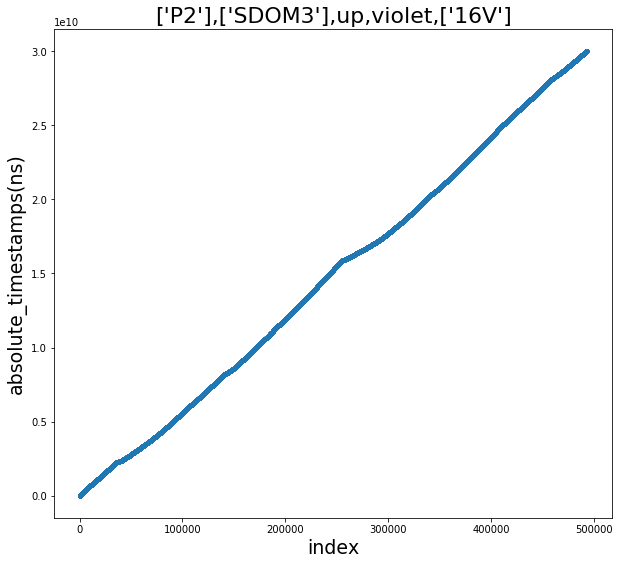

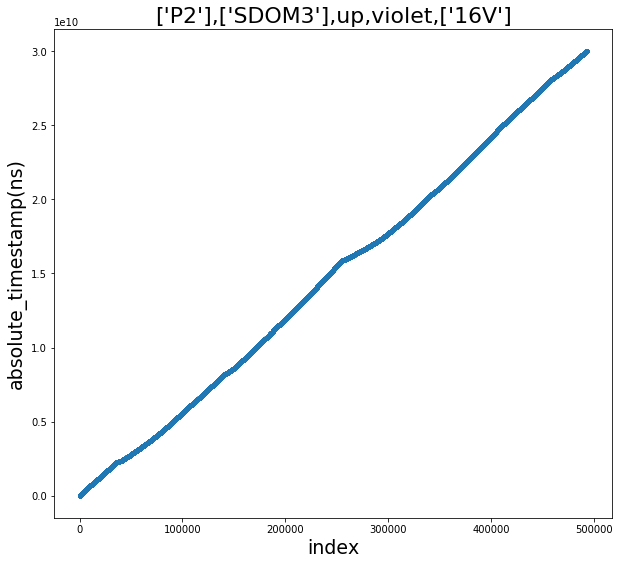

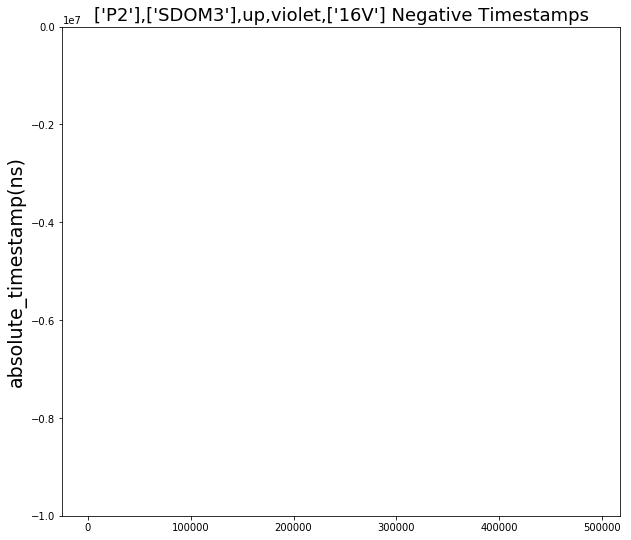

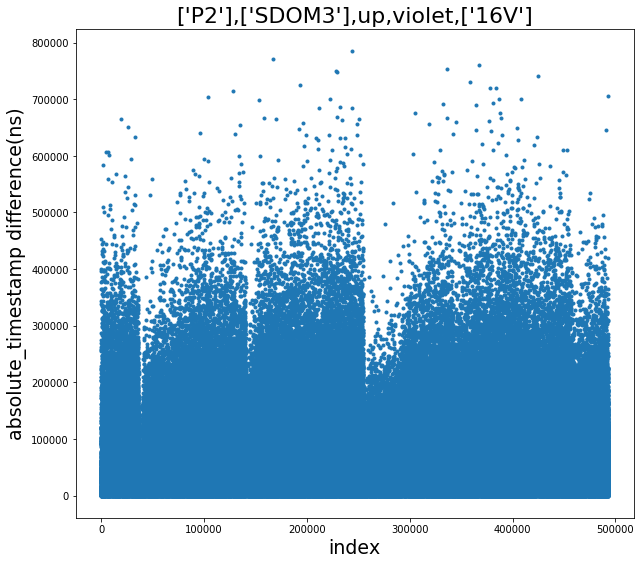

[]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:166: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:169: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:170: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:171: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:173: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the futur

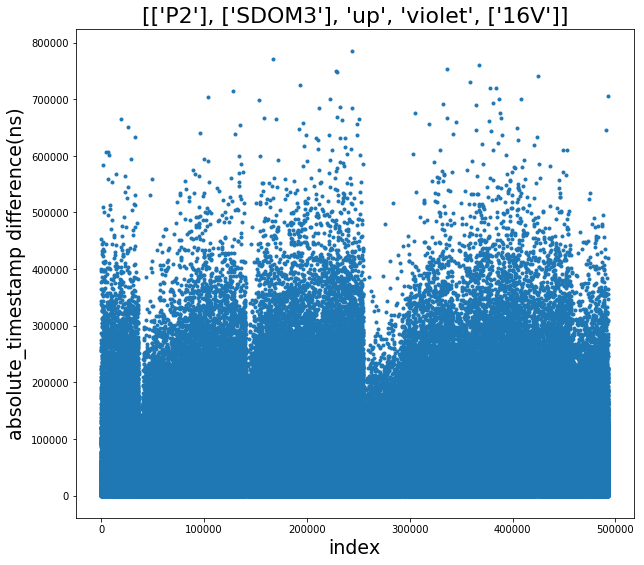

0.6594039037690719


In [98]:
(abs_elim_3, rising_0_elim_3, rising_1_elim_3, rising_2_elim_3, rising_3_elim_3,
 falling_0_elim_3, falling_1_elim_3, falling_2_elim_3, falling_3_elim_3, POCAM_num, values,
atstamp, p_jumps, dt_mean, f_r, values, file_path, SDOM_num, PMT) = d.P_S_used()

[ 1  2  3  4  5  6  7  9 11 12 15 17 18 22 23 24 25 26 27 28 29 30 31 32
 33 34 37 38 40 41 42 43 46 47 50 51 52 53 54 55 57 58 59 60 61 62 64 65
 66 67 68 69]


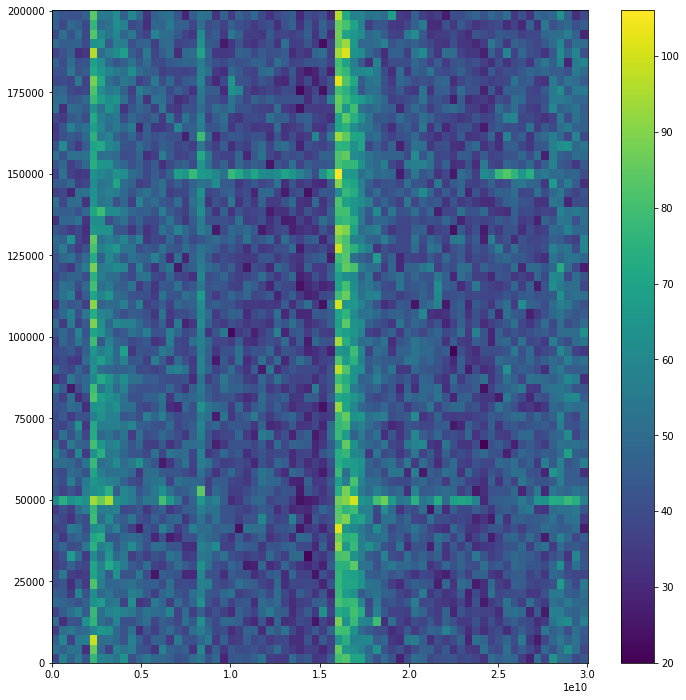

In [101]:
abs_elim, BinsHist, JumpIndex, xedges, yedges, POCAM_bins, POCAM_diff = HIST2D(70)

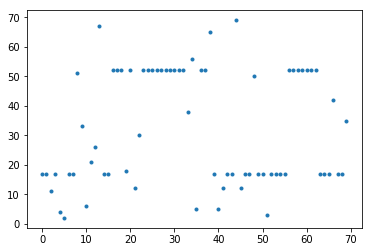

In [102]:
plt.plot(POCAM_bins, '.')

run# 0
b 1 Max 1
select size 2992
median -  48720.41642601375
a 1 1 min
run# 1
b 2 Max 2
select size 3115
median -  48728.24095916591
a 2 2 min
run# 2
b 3 Max 3
select size 3177
median -  31880.172237552993
a 3 3 min
run# 3
b 4 Max 4
select size 3168
median -  48712.09377620838
a 4 4 min
run# 4
b 5 Max 5
select size 3074
median -  11950.803706652645
a 5 5 min
run# 5
b 6 Max 6
select size 5134
median -  5966.362150533445
a 6 6 min
run# 6
b 7 Max 7
select size 4112
median -  48719.426038938545
a 7 7 min
run# 7
b 9 Max 9
select size 7708
median -  97137.93578513146
a 9 9 min
run# 8
b 11 Max 11
select size 6779
median -  54009.169110158866
a 11 11 min
run# 9
b 12 Max 12
select size 3149
median -  60684.70733924444
a 12 12 min
run# 10
b 15 Max 15
select size 9275
median -  102771.8870965348
a 15 15 min
run# 11
b 17 Max 17
select size 6140
median -  97352.85428253692
a 17 17 min
run# 12
b 18 Max 18
select size 2922
median -  148922.00574586124
a 18 18 min
run# 13
b 22 Max 22
select size 1315

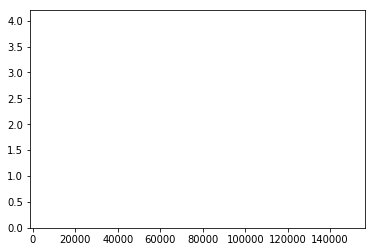

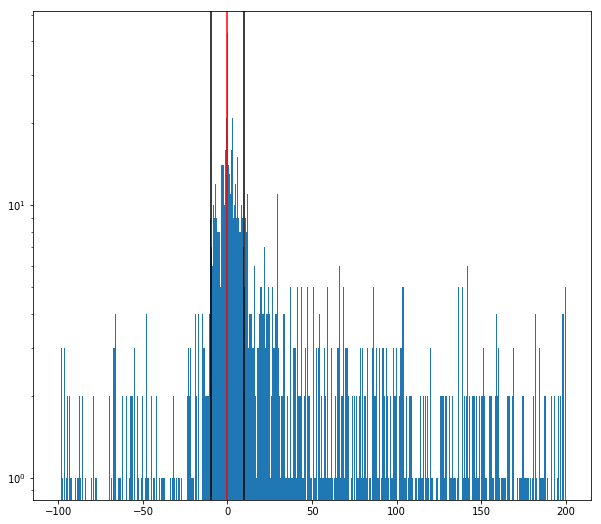

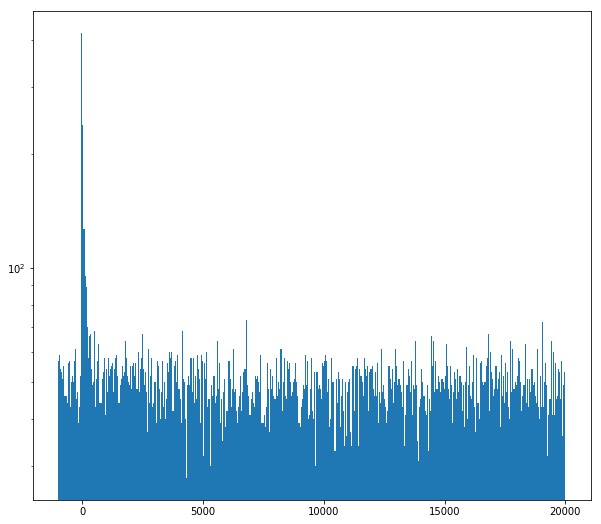

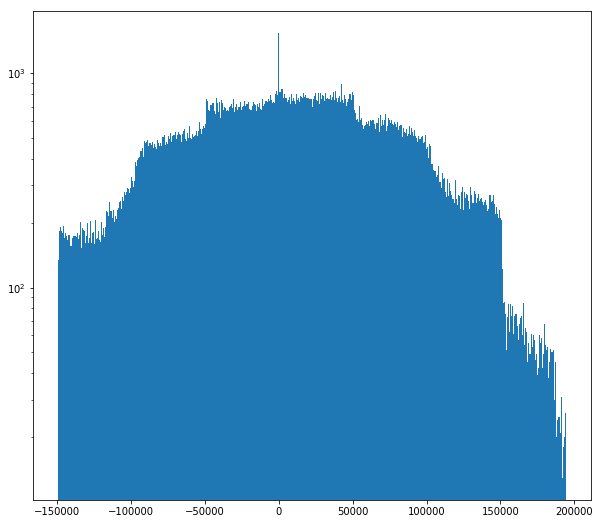

In [110]:
t_res_all4, peak_1, num_events4 = calc_res(5, 1, 1)

In [111]:
RunTime4, error_rtime4 = run_time(atstamp, p_jumps)

timestamp of the last event -  30028868592.48047
eliminating high jumps and summing -  30021671485.06738
run time -  30021671485.06738


In [112]:
distance4, angle_cr4 = angl_dist()

In [113]:
eve_p_sec4, error_nevents4 = correction(num_events4, angle_cr4, RunTime4)

In [114]:
eve_p_sec4

12.585932704580221

In [115]:
eve_p_sec = np.array([eve_p_sec1, eve_p_sec2, eve_p_sec3, eve_p_sec4])
distance = np.array([distance1, distance2, distance3, distance4])

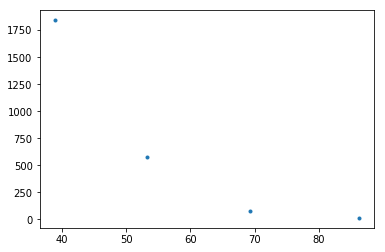

In [116]:
plt.plot(distance, eve_p_sec, '.')

In [117]:
sigg = np.array([eve_p_sec[0] * (np.sqrt((1/error_nevents1) + (error_rtime1/RunTime1)**2)), 
                eve_p_sec[1] *(np.sqrt((1/(error_nevents2)) + (error_rtime2/RunTime2)**2)),
                eve_p_sec[2] *((np.sqrt(1/(error_nevents3)) + (error_rtime3/RunTime3)**2)),
                eve_p_sec[3] *((np.sqrt(1/(error_nevents4)) + (error_rtime4/RunTime4)**2))])

In [118]:
def chi(N):
    chisq = np.sum(((eve_p_sec - ((N[0]/(distance**2))*np.exp(-distance/N[1])))/sigg)**2)
    return chisq

In [119]:
x0 = [10, 20]
par = minimize(chi,x0, method = 'Powell')

In [120]:
par.x[1]

15.81870870651689

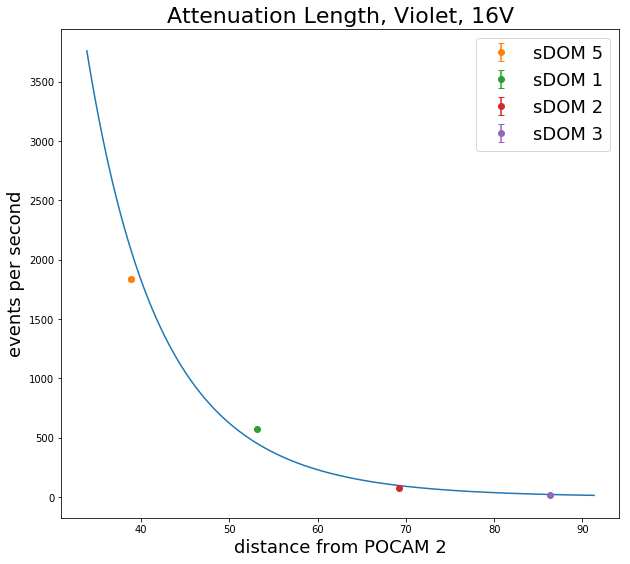

In [121]:
distance1 = np.linspace(distance.min() - 5, distance.max() + 5, 1000)
curve = (par.x[0]/(distance1**2)) * np.exp(-distance1/par.x[1])

plt.figure(figsize=(10,9))
plt.plot(distance1, curve)
#plt.plot(dist_set1, eve_w_angle, '.')
plt.errorbar(distance[0], eve_p_sec[0], yerr=sigg[0], fmt = 'o', markersize=6, capsize=3, label = 'sDOM 5')
plt.errorbar(distance[1], eve_p_sec[1], yerr=sigg[1], fmt = 'o', markersize=6, capsize=3, label = 'sDOM 1')
plt.errorbar(distance[2], eve_p_sec[2], yerr=sigg[2], fmt = 'o', markersize=6, capsize=3, label = 'sDOM 2')
plt.errorbar(distance[3], eve_p_sec[3], yerr=sigg[3], fmt = 'o', markersize=6, capsize=3, label = 'sDOM 3')
plt.legend(loc = 'best', fontsize = 18)
#plt.ylim(100, 200)
plt.xlabel('distance from POCAM 2', fontsize = 18)
plt.ylabel('events per second', fontsize = 18)
plt.title('Attenuation Length, Violet, 16V', fontsize = 22)   
plt.savefig(file_path + '/graphs/POCAM2, Violet, 16V, 5kHz' + 'attlength.jpeg', dpi = 200)